## 3 - Cleaned Data Assessment (Fixation on Surface)

##### Imports

In [1]:
import os
import pandas as pd
import numpy as np
import scipy as su
# from typing import Dict
# from scipy.signal import
# from scikit-learn import

import matplotlib.pyplot as plt
import seaborn as sns

import dask.dataframe as dd

##### Data Loading (cleaned)

In [2]:
# Load CLEANED ddfs into dictionary (exception for 'surf_position' as a df)
root_dir = './cleaned_data'
def load_cleaned_data(root_dir, exception=False): # Get csv file reads into one dictionary
    data = {}
    for file in os.listdir(root_dir):
        file_path = os.path.join(root_dir, file)
        file_name = os.path.splitext(file)[0]  # file name without '.csv'
        if file.endswith('.csv') and file != 'surf_position.csv':
            data[file_name] = dd.read_csv(file_path)  # read and attach to dict
        elif exception and file == 'surf_position.csv':
            data[file_name] = pd.read_csv(file_path, converters=converters)  # read as normal and attach to dict
    return data
def parse(filedata):
    for line in filedata.split('\n'): 
        line = line.strip()
        if not line:
            continue  # skip empty lines
        row = ast.literal_eval(line) # evaluate the str into obj
    return row
converters = {
    "img_to_surf_trans": parse,
    "surf_to_img_trans": parse,
}

data = load_cleaned_data(root_dir)
participant_ids = [1,2,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

In [3]:
gui_ddf = data['gui_data']
gui_df = gui_ddf.compute()
gui_df['block_data'] = gui_df['block_data'].apply(lambda x: eval(x))

In [4]:
ddf = data['surf_fixation']
df = ddf.compute().iloc[:, 1:]

### 1. Basic statistics
- ...

In [33]:
display(df.describe())

participant_id  world_timestamp    fixation_id  start_timestamp  \
count   311199.000000    311199.000000  311199.000000    311199.000000   
mean        10.977079    -81410.783868    8364.081636    -81410.784127   
std          5.741736    296384.524144    4908.417633    296384.524122   
min          1.000000   -672842.718256       0.000000   -672842.855135   
25%          6.000000      3931.649465    4141.000000      3931.649317   
50%         11.000000     18663.389266    8292.000000     18663.399790   
75%         16.000000     85597.270113   12432.000000     85597.272055   
max         20.000000    353175.851217   20180.000000    353175.850196   

            duration     dispersion     norm_pos_x     norm_pos_y  \
count  311199.000000  311199.000000  311199.000000  311199.000000   
mean      161.340905       1.219475       0.495433       0.670954   
std        51.778554       0.270836       0.154296       0.223541   
min        80.000000       0.011841      -0.499300      -0.496727   
25%       110.603000       1.055259       0.391694       0.493582   
50%       165.965000       1.326108       0.479088       0.710202   
75%       217.130500       1.435140       0.588881       0.848278   
max       220.000000       1.500000       1.499948       1.497823   

        dispersion.1  world_timestamp_unix  start_timestamp_unix  
count  311199.000000          3.111990e+05          3.111990e+05  
mean        1.219475          1.711008e+09          1.711008e+09  
std         0.270836          4.465524e+05          4.465524e+05  
min         0.011841          1.710323e+09          1.710323e+09  
25%         1.055259          1.710507e+09          1.710507e+09  
50%         1.326108          1.711035e+09          1.711035e+09  
75%         1.435140          1.711467e+09          1.711467e+09  
max         1.500000          1.711630e+09          1.711630e+09

### 2. Quality Assessment
Confidence, Duration, Dispersion, Normalized position, Spatial distributions +correlations +boxplots

##### Duration distribution
- Higher concentration closer to the bounds (80, 220)

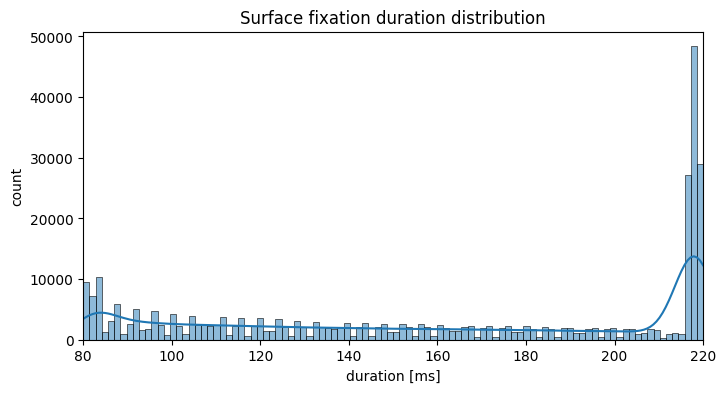

In [22]:
plt.figure(figsize=(8, 4))
sns.histplot(ddf['duration'], bins=100, kde=True)
plt.title(f'Surface fixation duration distribution')
plt.xlabel('duration [ms]')
plt.ylabel('count')
plt.xlim(80, 220)
plt.show()

##### Dispersion distribution
- Higher concentration closer to the upper bound (1.5)

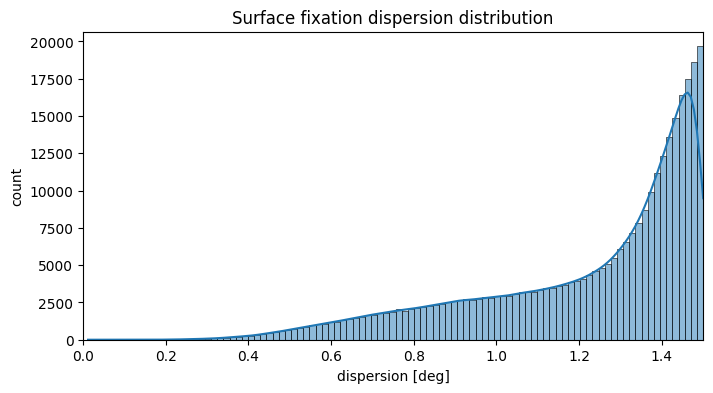

In [23]:
plt.figure(figsize=(8, 4))
sns.histplot(ddf['dispersion'], bins=100, kde=True)
plt.title(f'Surface fixation dispersion distribution')
plt.xlabel('dispersion [deg]')
plt.ylabel('count')
plt.xlim(0, 1.5)
plt.show()

##### Duration boxplot (pid)
- Good

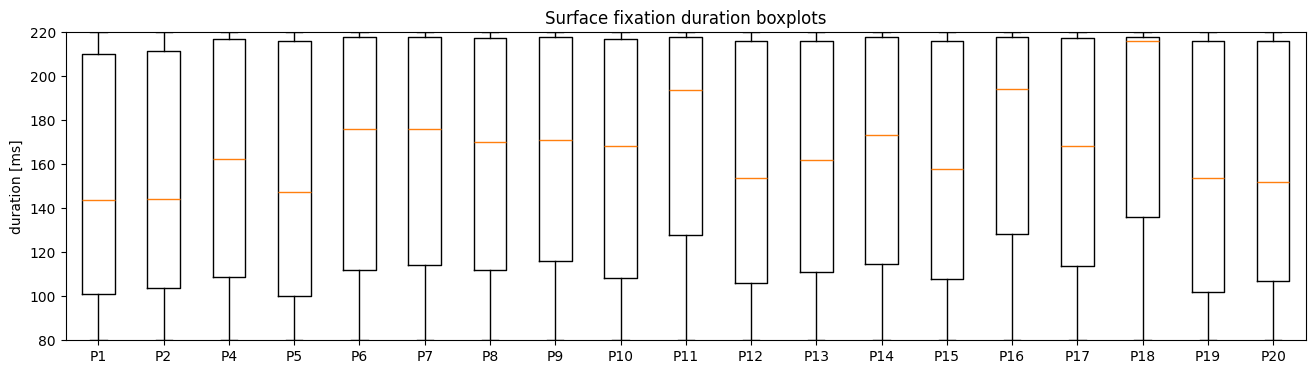

In [6]:
grouped_ids = [participant_ids[i:i+19] for i in range(0, len(participant_ids), 19)] #group ids
for group in grouped_ids: #iterate groups
    participants_ddf = [ddf[ddf['participant_id'] == pid]['duration'] for pid in group] #get group's sub-ddfs
    plt.figure(figsize=(16, 4))
    plt.boxplot(participants_ddf, whis = 1.5)
    plt.title(f'Surface fixation duration boxplots')
    plt.ylabel('duration [ms]')
    plt.ylim(80, 220)
    plt.xticks(range(1, len(group) + 1), [f'P{pid}' for pid in group]) #single boxplots labels
    plt.show()

##### Dispersion boxplot (pid)
- Lower whiskers are NOT outliers

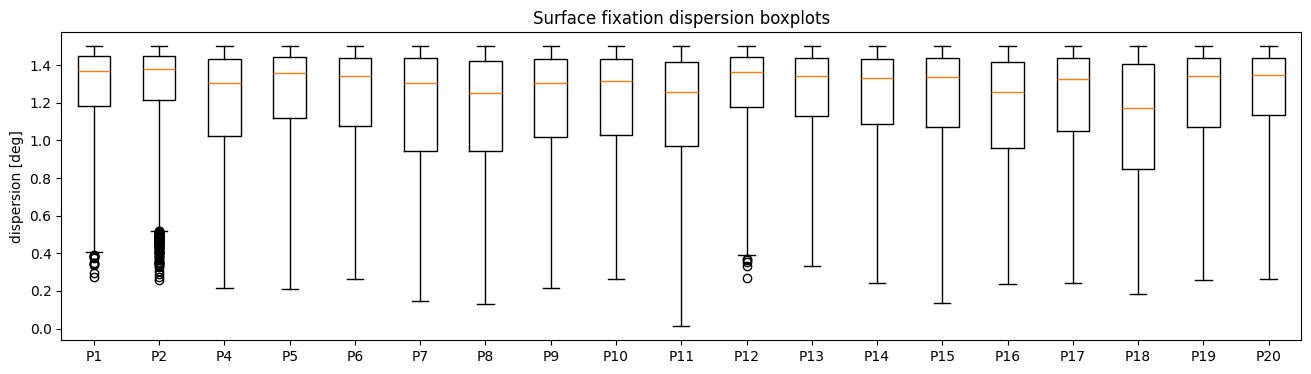

In [8]:
grouped_ids = [participant_ids[i:i+19] for i in range(0, len(participant_ids), 19)] #group ids
for group in grouped_ids: #iterate groups
    participants_ddf = [ddf[ddf['participant_id'] == pid]['dispersion'] for pid in group] #get group's sub-ddfs
    plt.figure(figsize=(16, 4))
    plt.boxplot(participants_ddf, whis = 3)
    plt.title(f'Surface fixation dispersion boxplots')
    plt.ylabel('dispersion [deg]')
    # plt.ylim(0, 1.5)
    plt.xticks(range(1, len(group) + 1), [f'P{pid}' for pid in group]) #single boxplots labels
    plt.show()

##### Spatial distribution with surface
- Many relatable pattern of fixations (wider on top side of the surface)
- P11 has lot of fixations right above the surface (glasses adjustment?)
- p17 barely looks off-surface

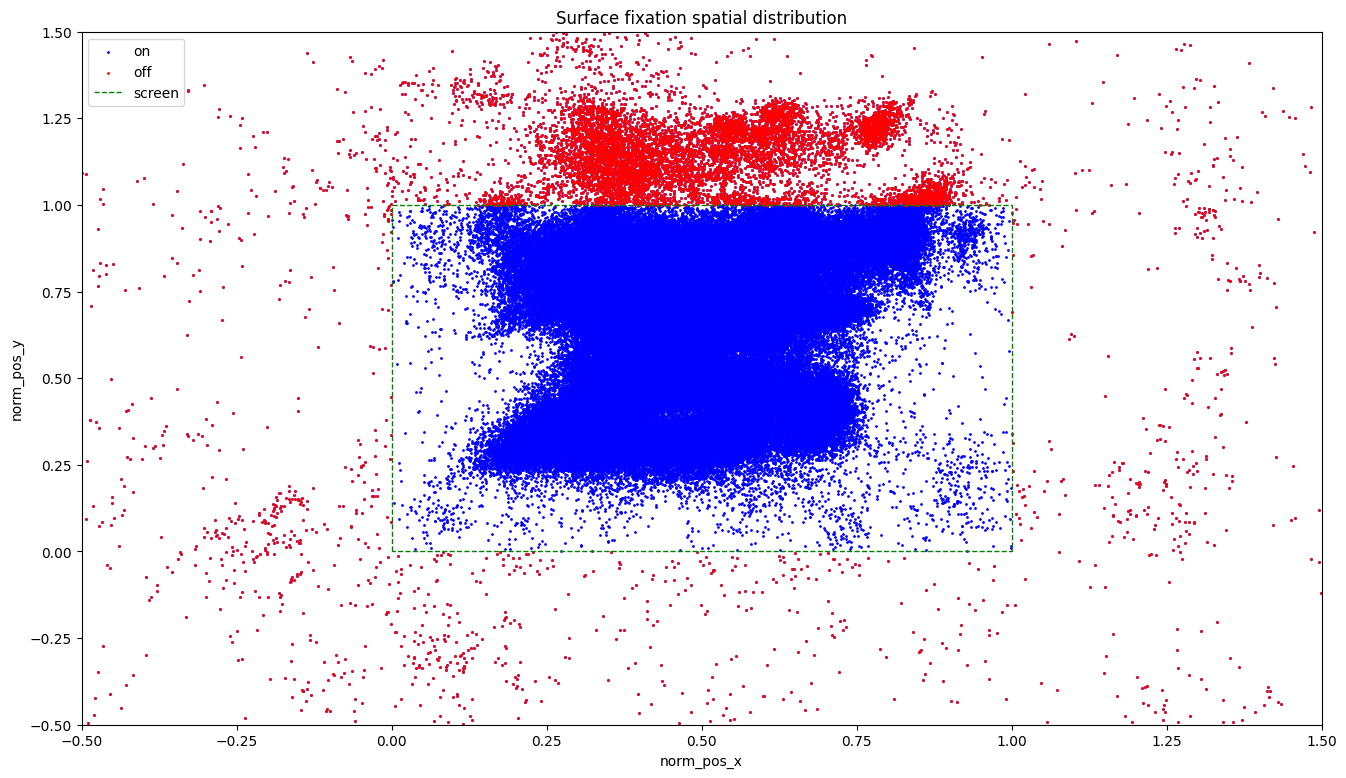

In [31]:
df['relative_timestamp'] = df.groupby('participant_id')['start_timestamp'].transform(lambda x: x - x.min())
on_surface = df[df['on_surf'] == False]
plt.figure(figsize=(16, 9))
plt.scatter(df['norm_pos_x'], df['norm_pos_y'], s=1, color='blue', label='on')
plt.scatter(on_surface['norm_pos_x'], on_surface['norm_pos_y'], s=1, color='red', label='off')

# Draw closed rectangle
rectangle_x = [0, 0, 1, 1, 0]
rectangle_y = [0, 1, 1, 0, 0]
plt.plot(rectangle_x, rectangle_y, color='green', linestyle='--', linewidth=1, label='screen')

plt.title(f'Surface fixation spatial distribution')
plt.xlabel('norm_pos_x')
plt.ylabel('norm_pos_y')
plt.xlim(-0.5, 1.5)
plt.ylim(-0.5, 1.5)
plt.legend(loc='upper left')
plt.show()

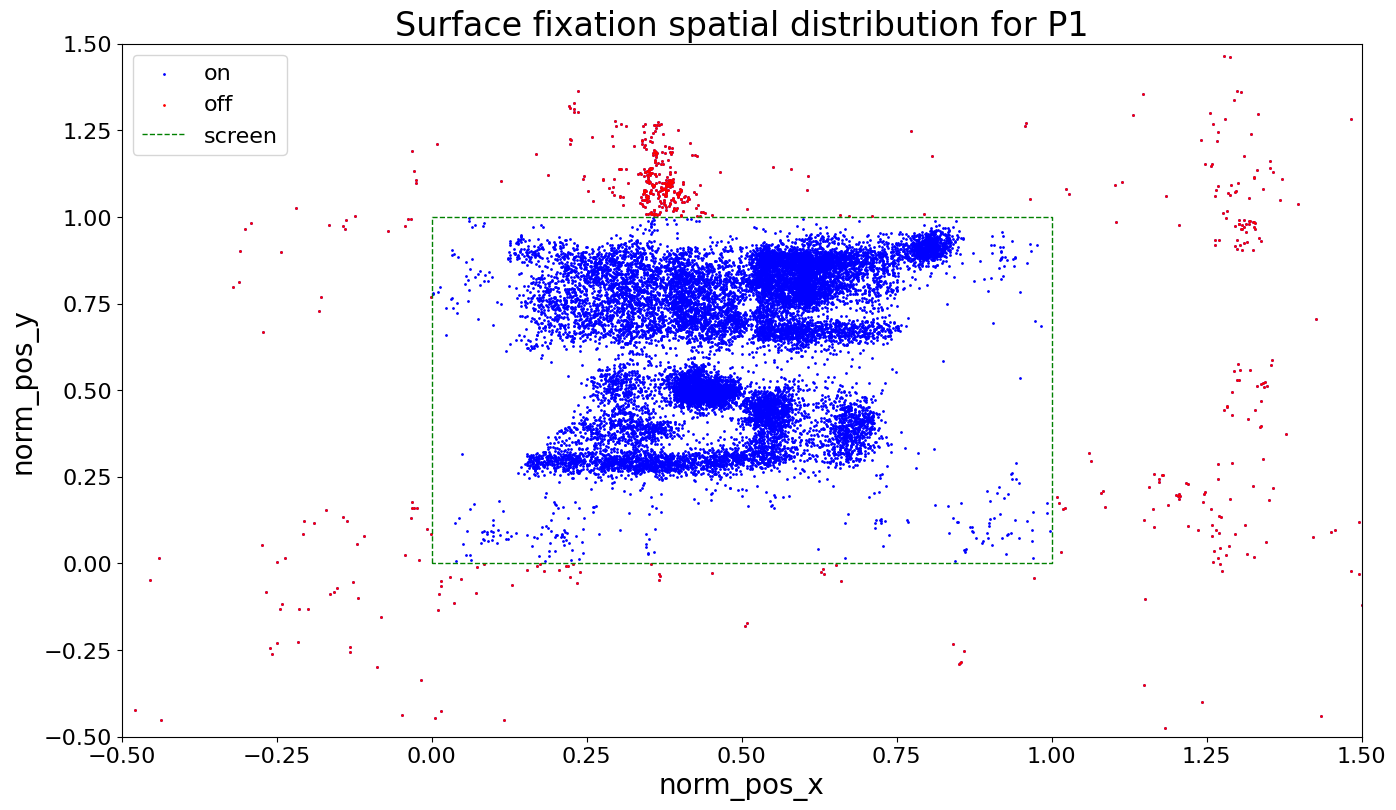

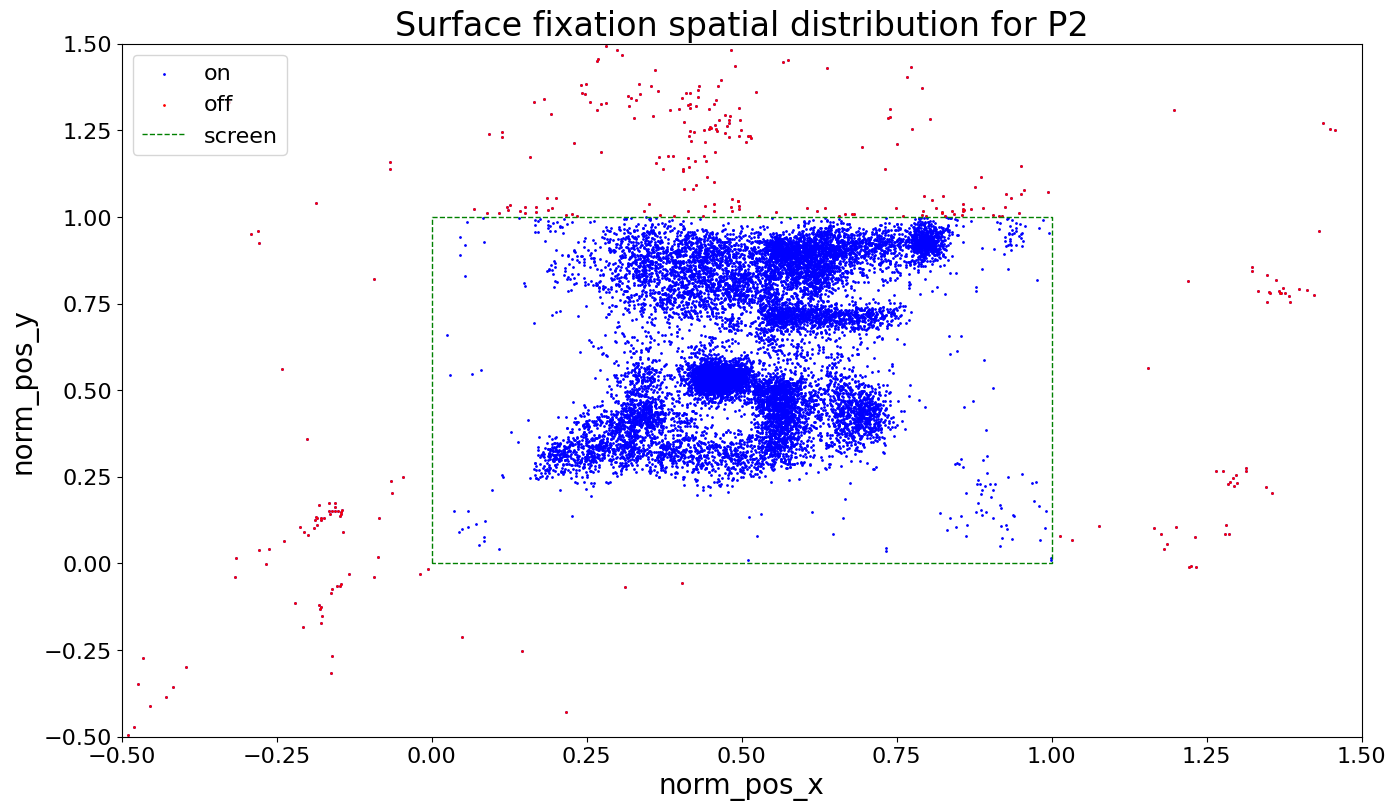

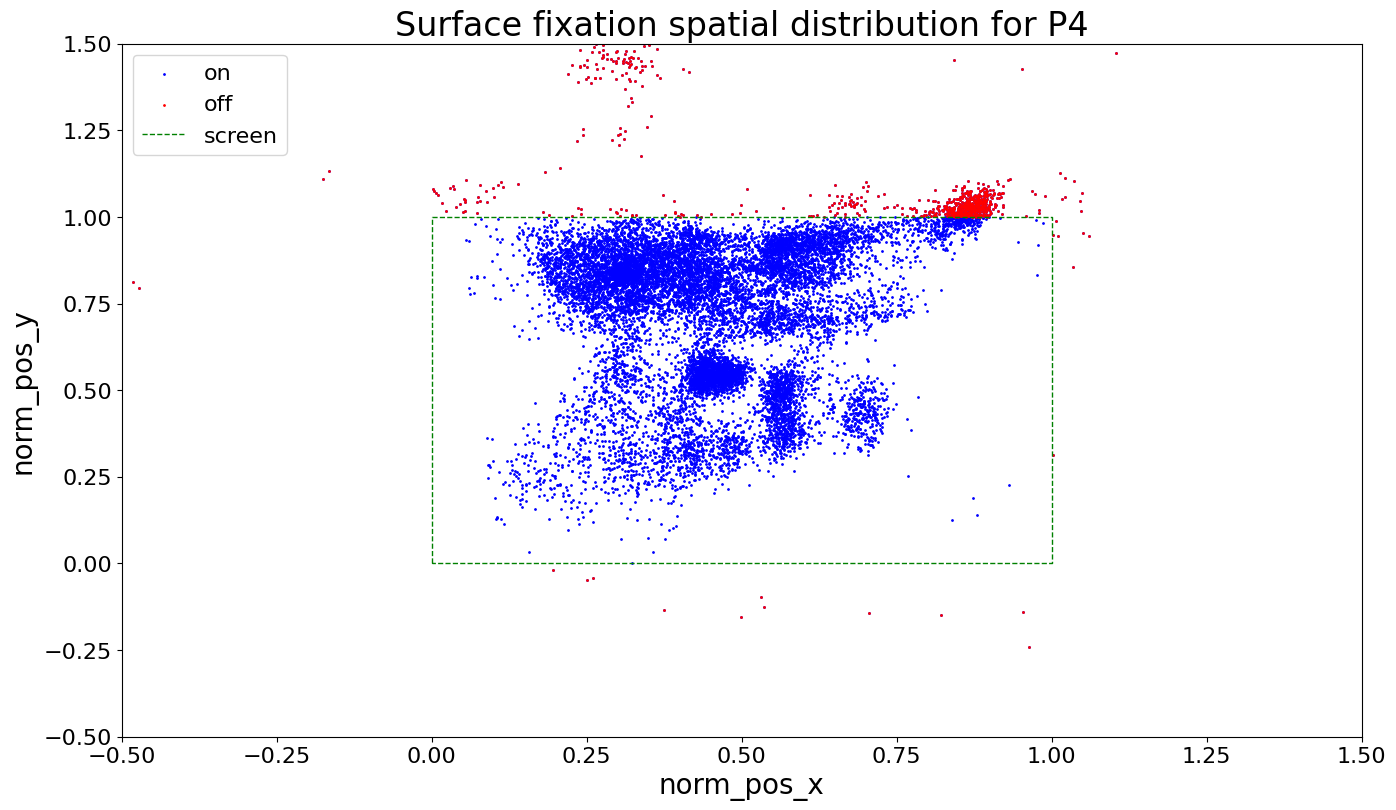

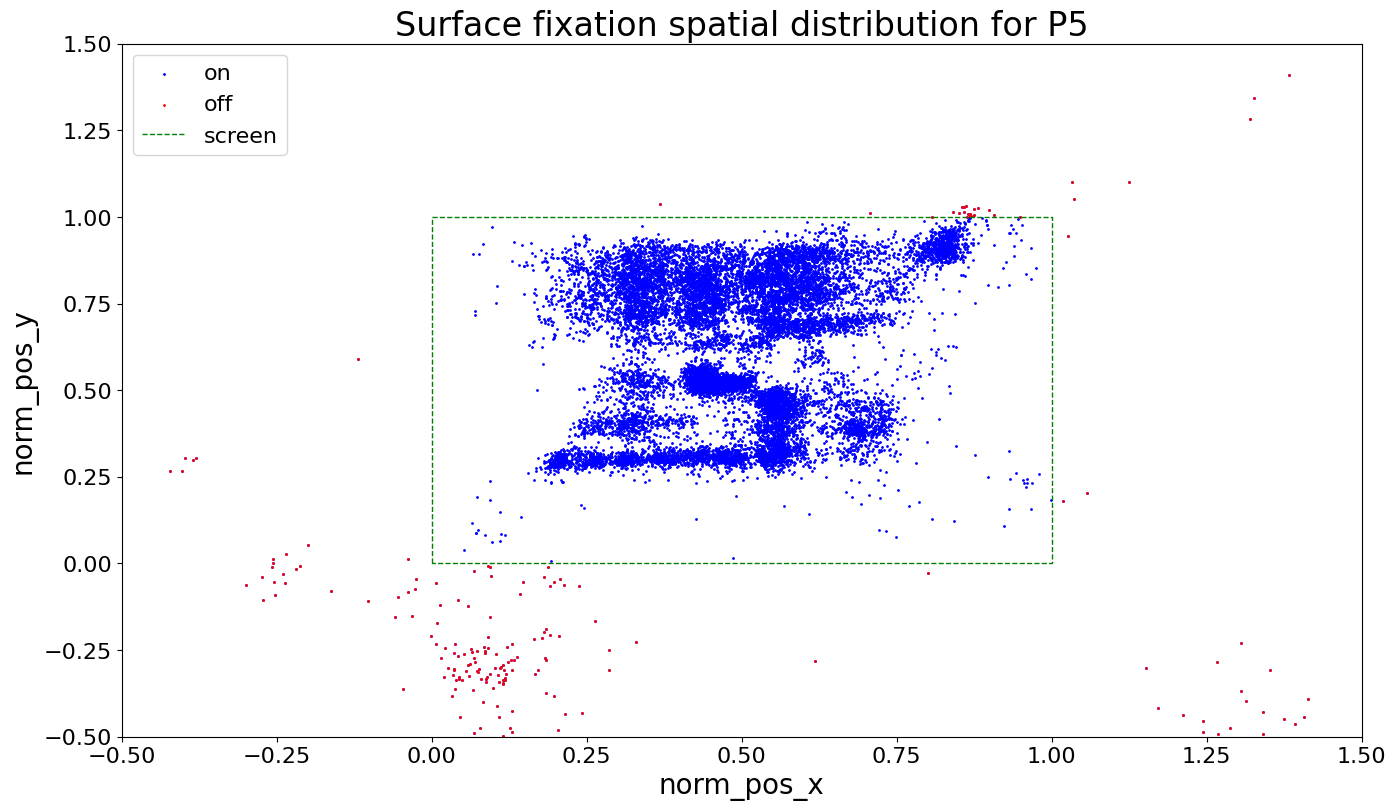

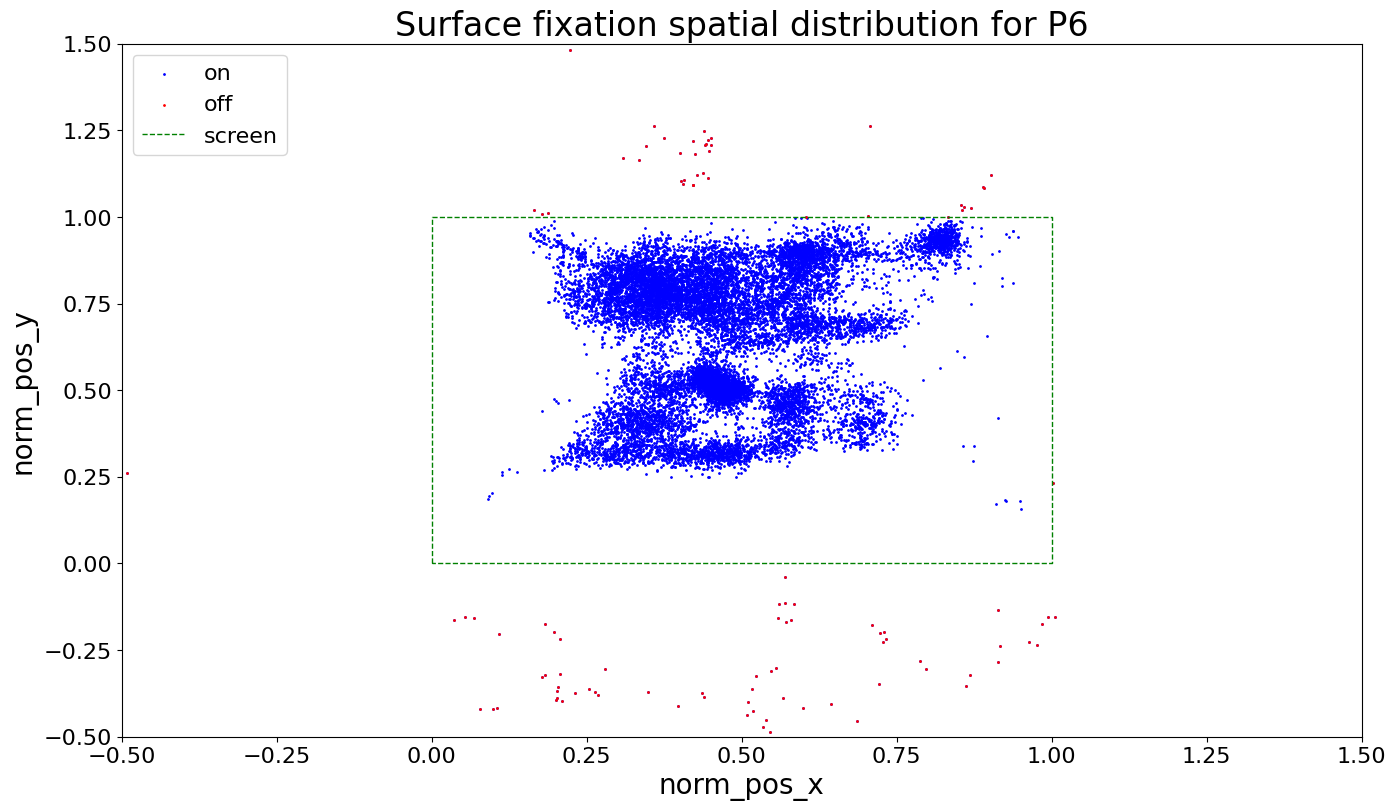

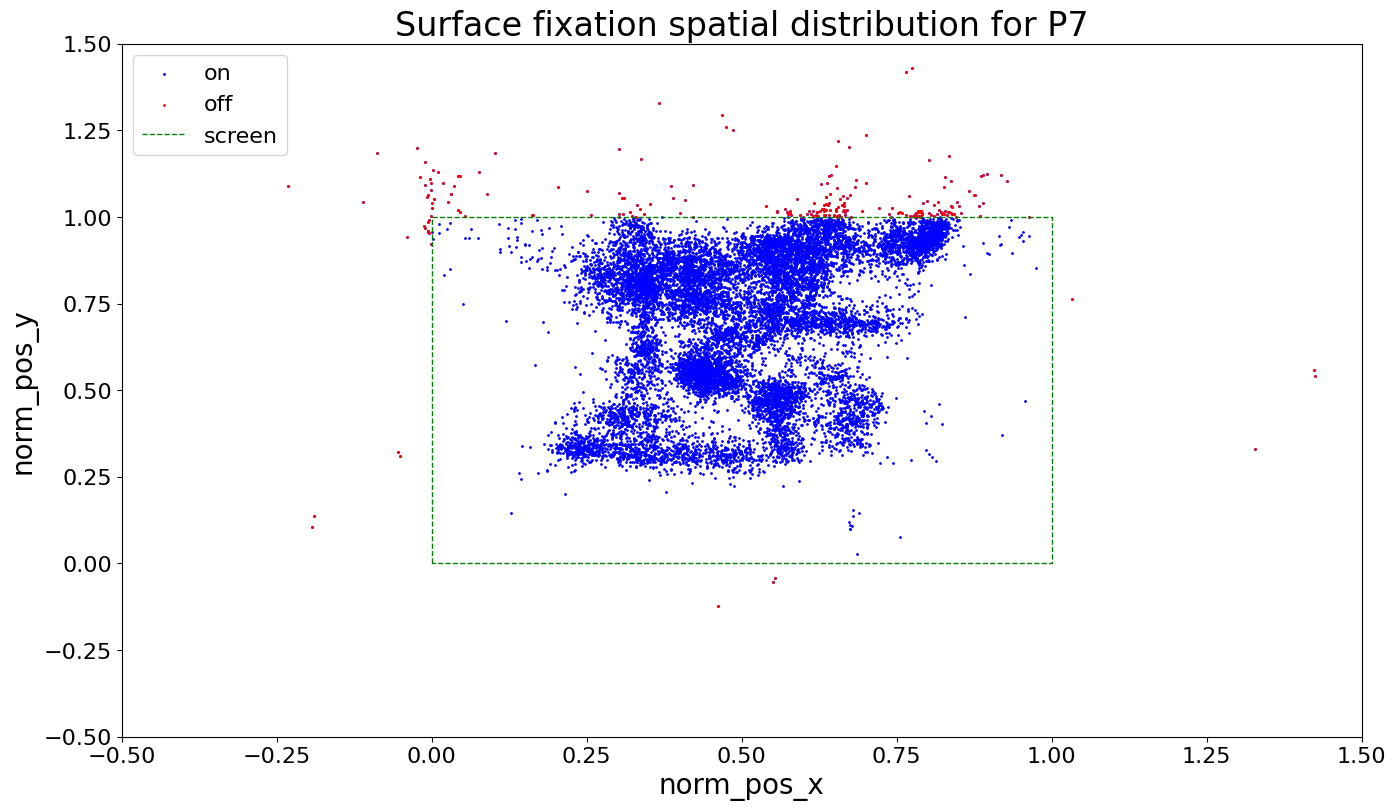

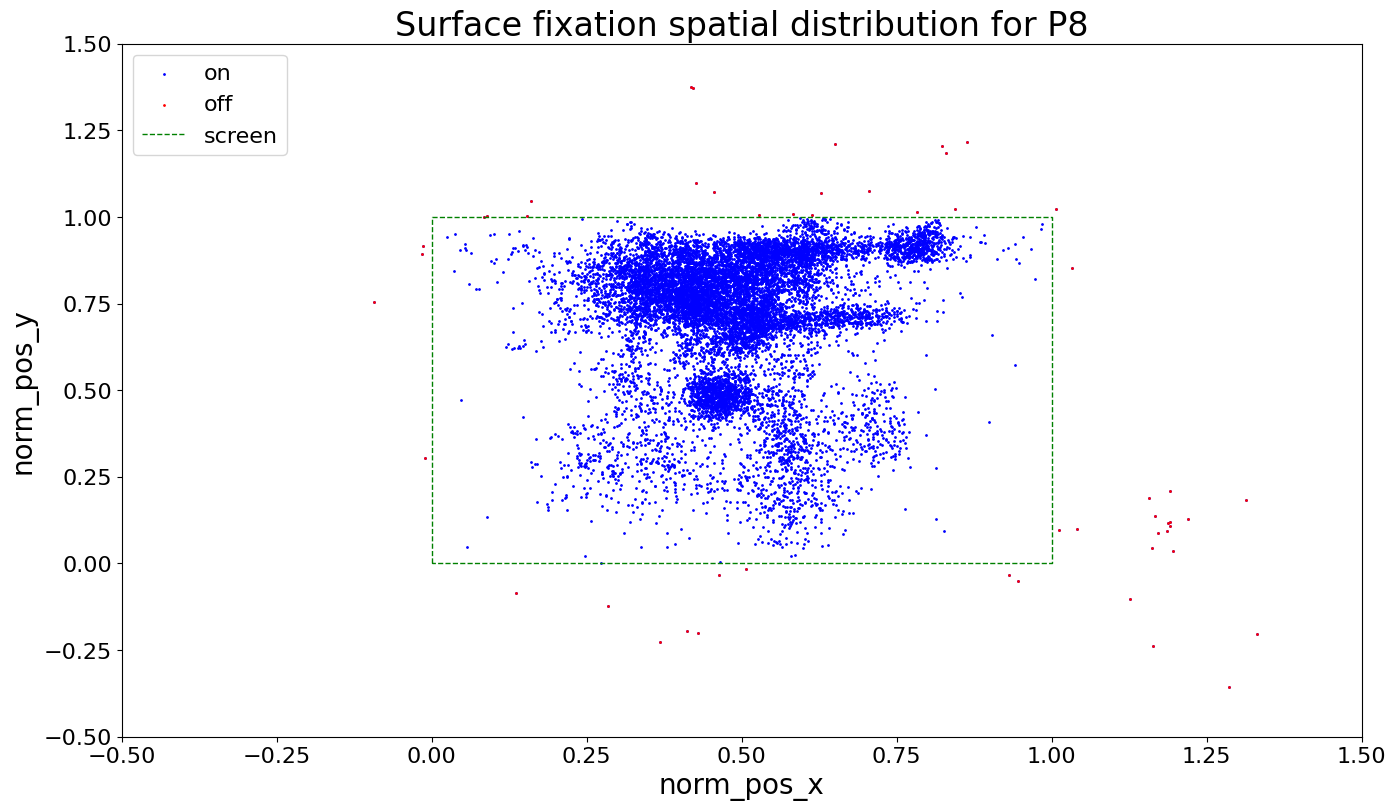

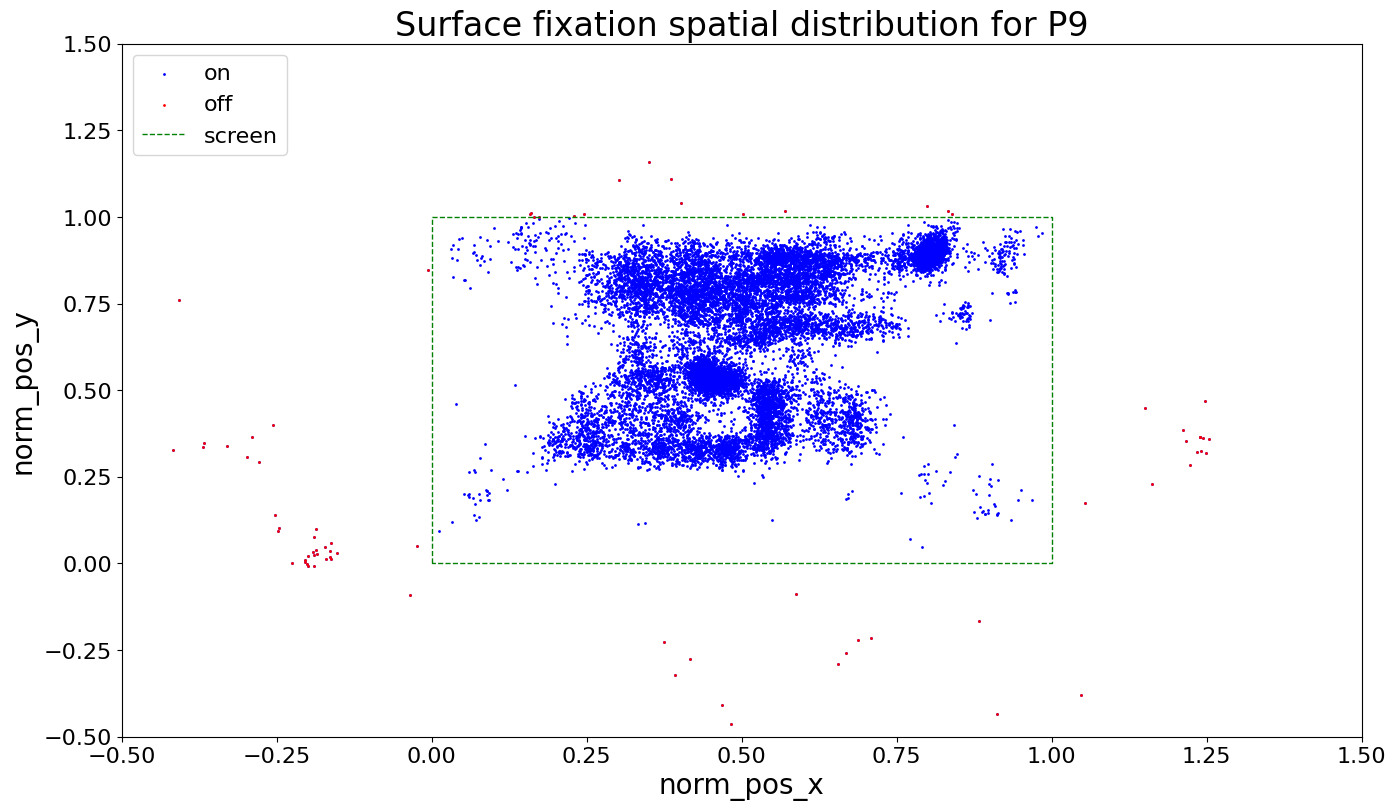

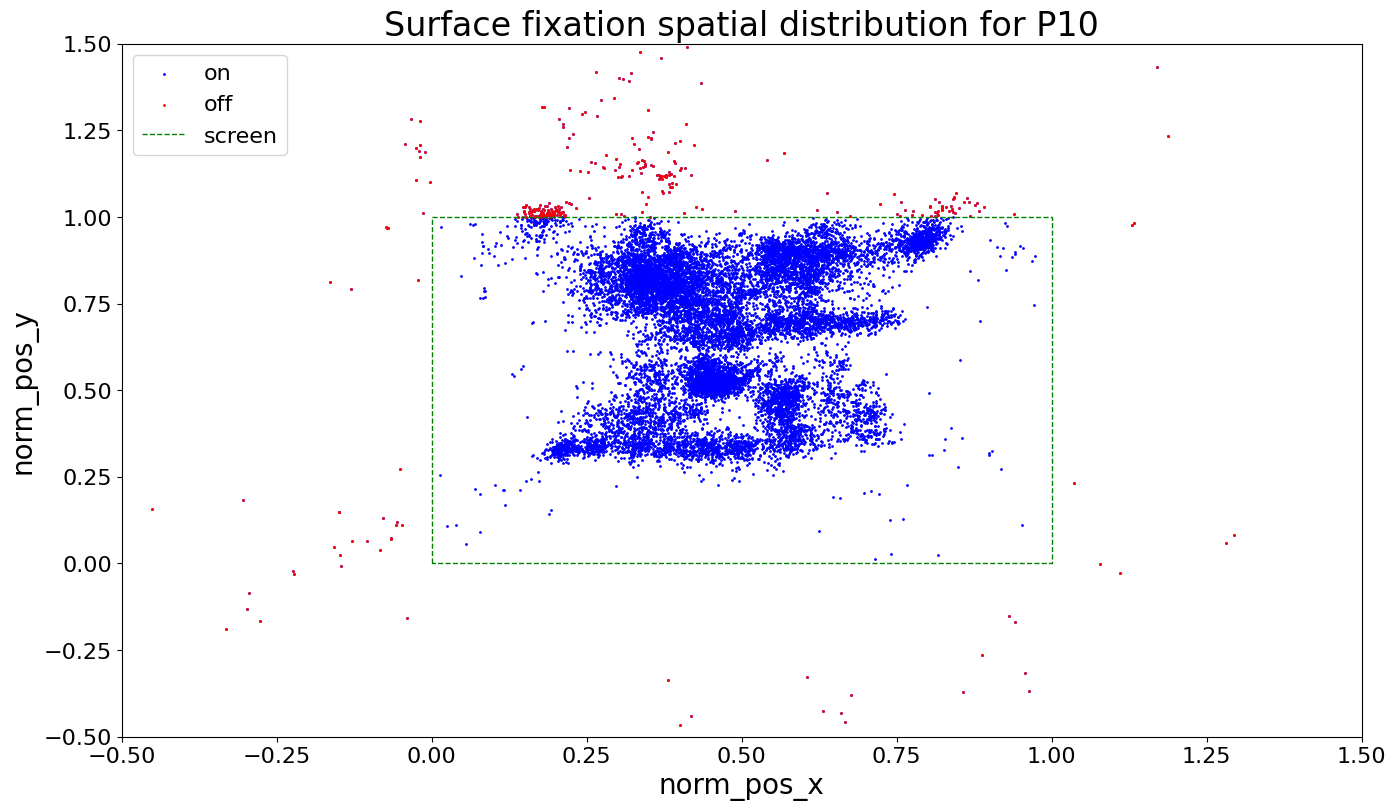

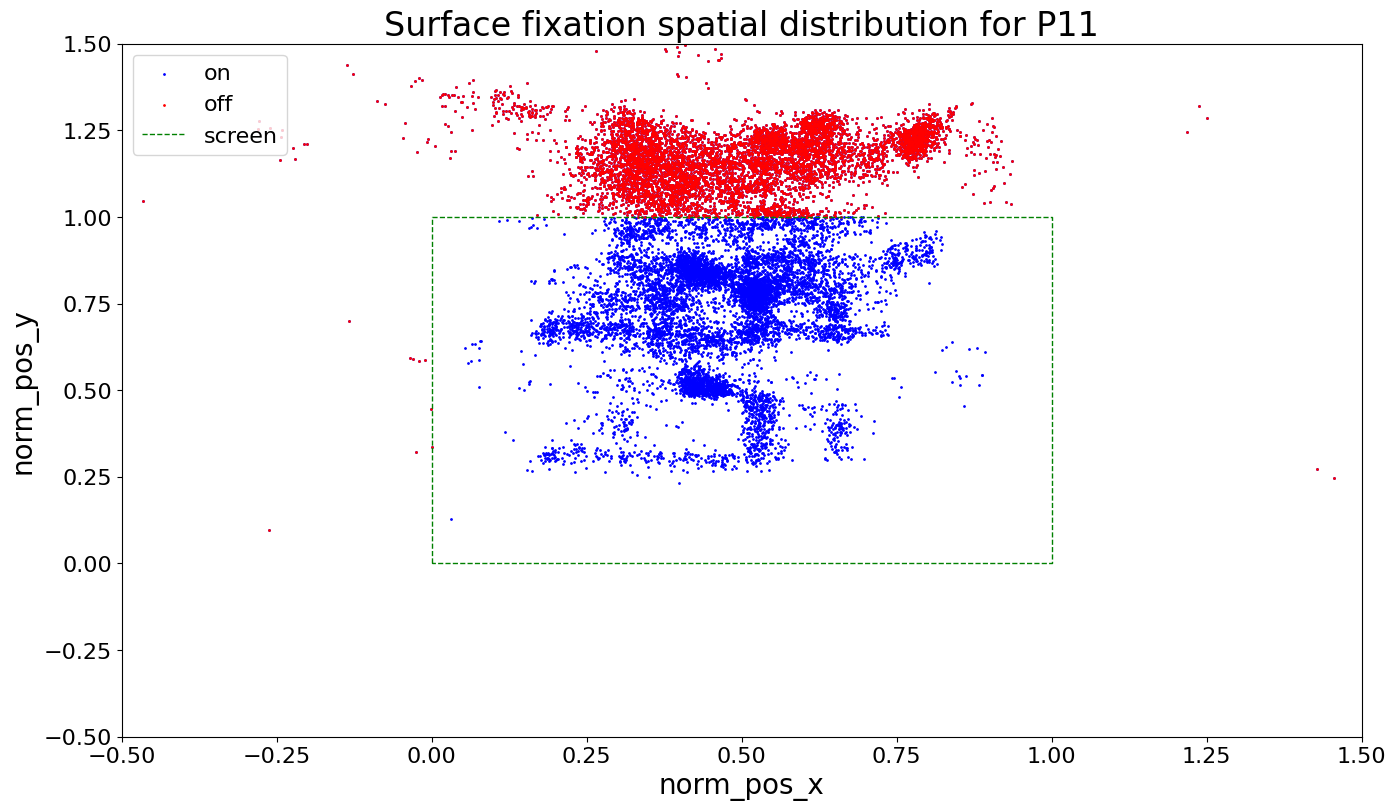

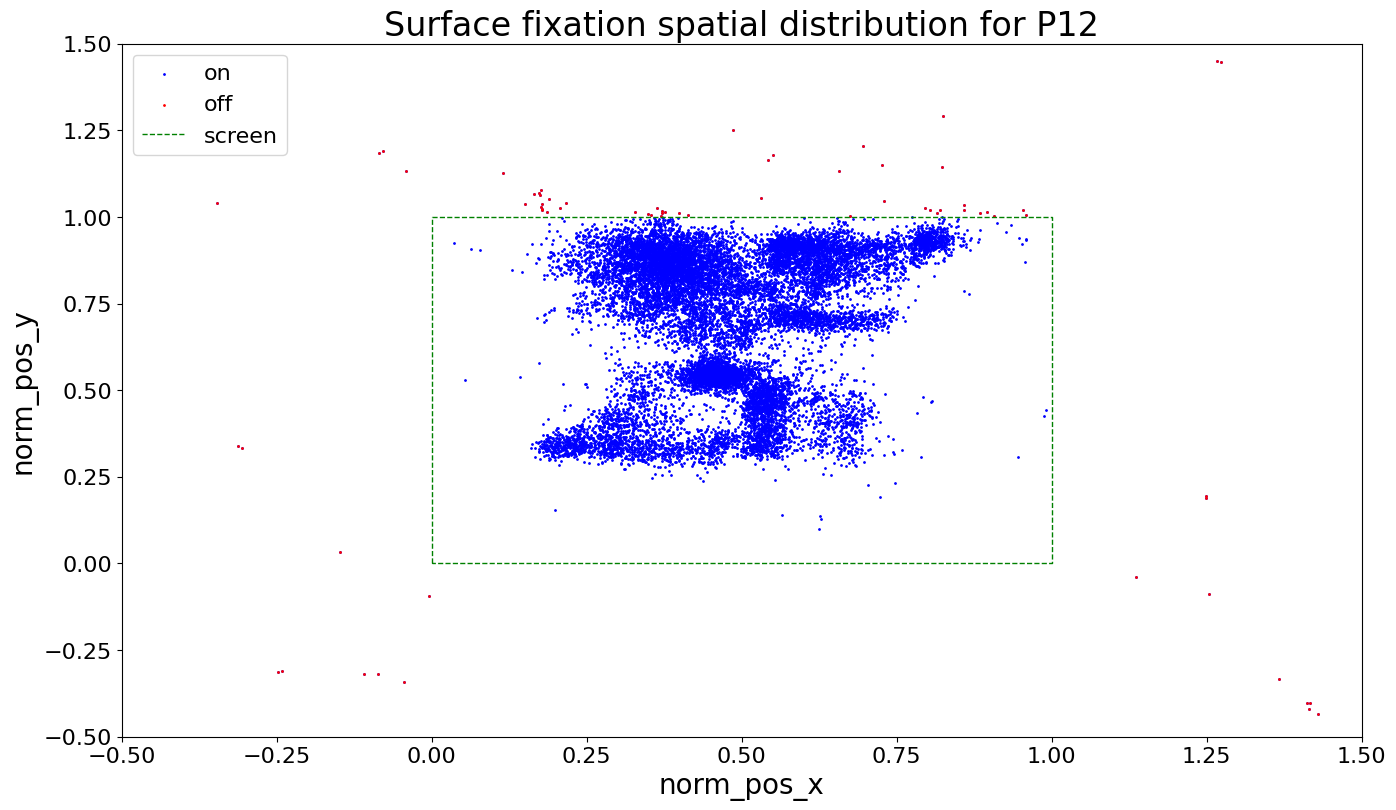

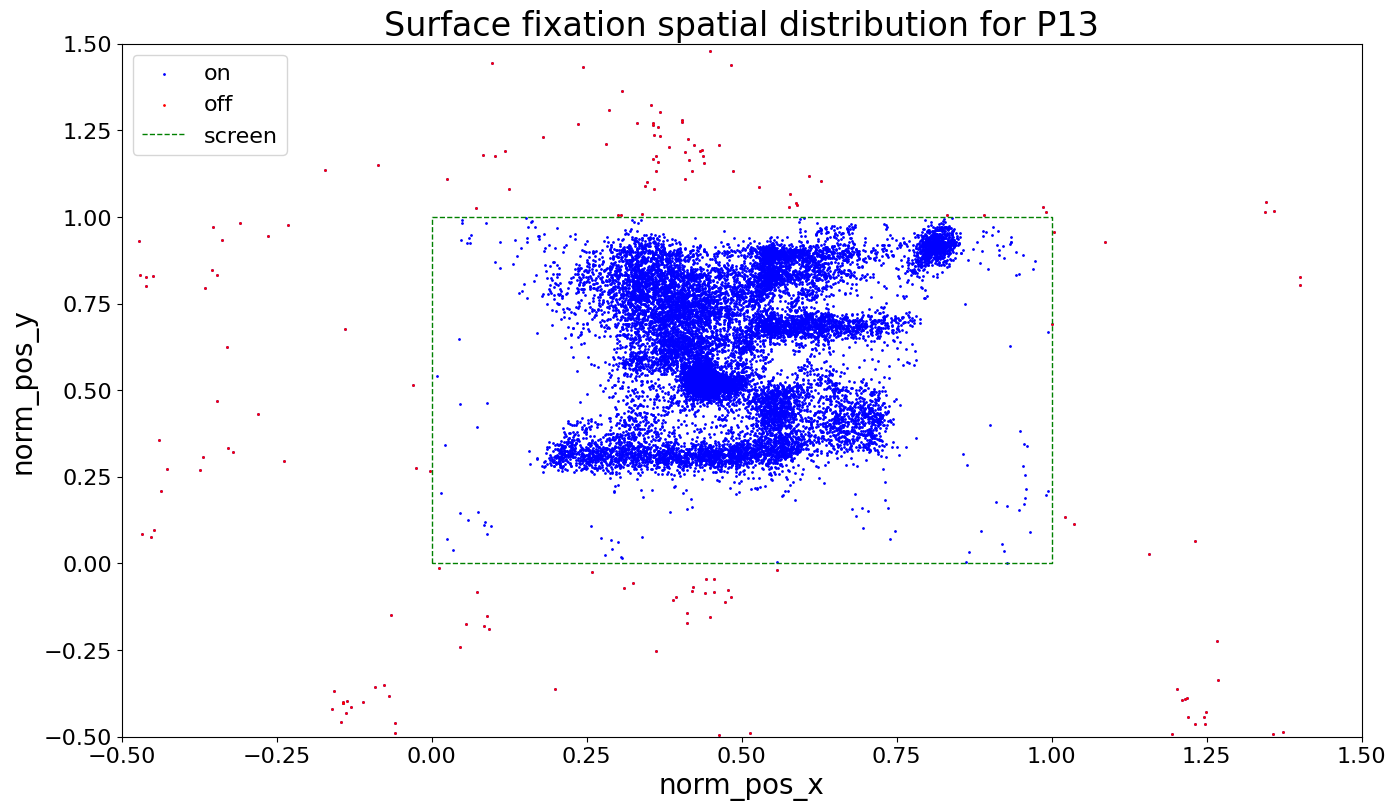

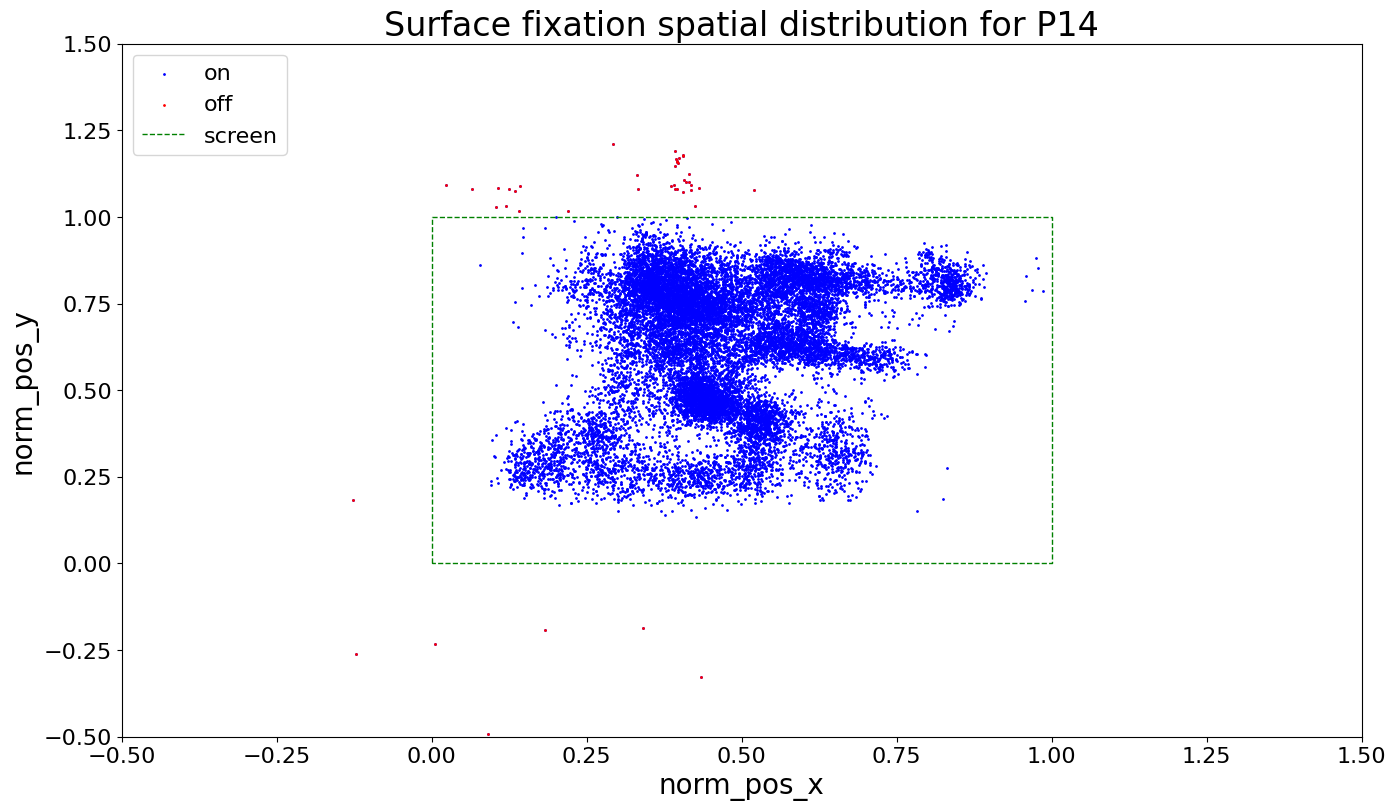

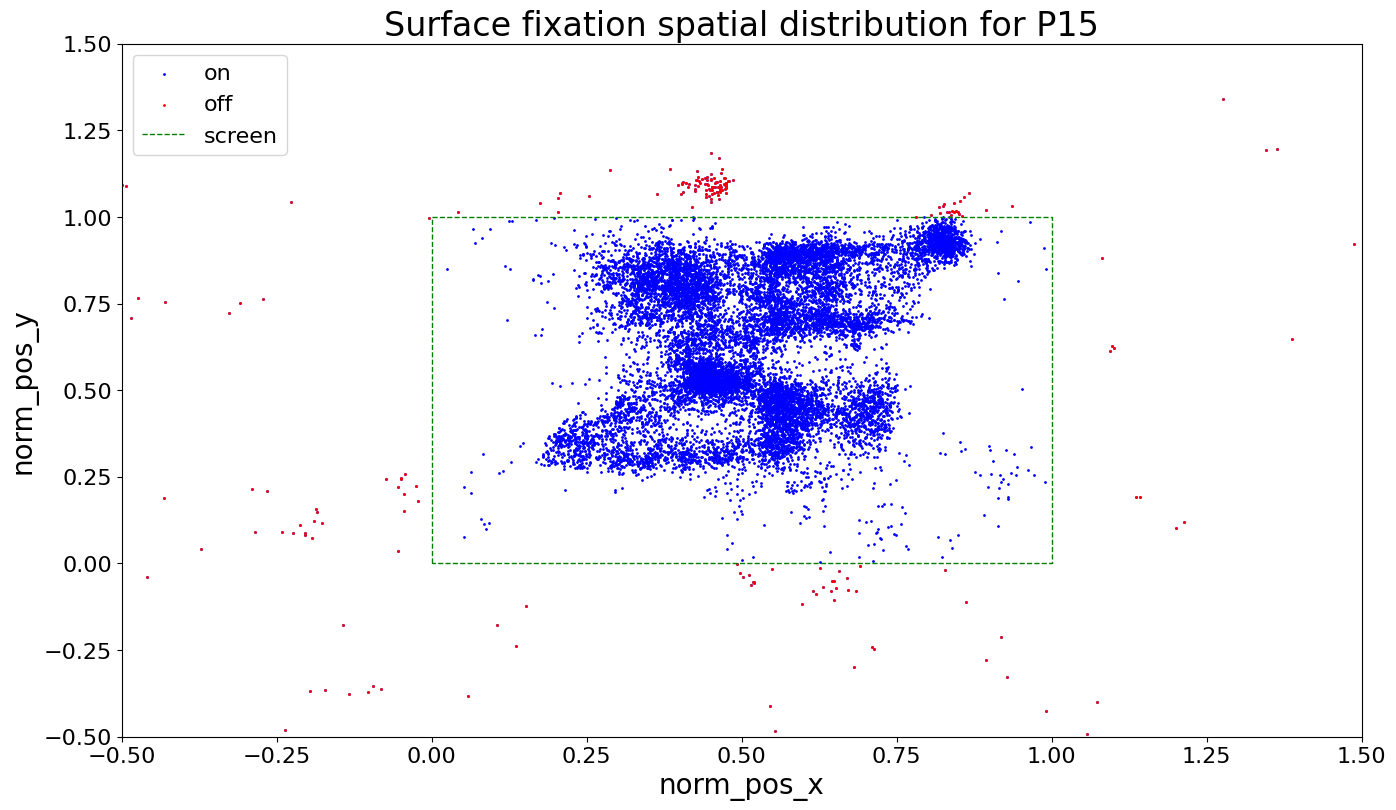

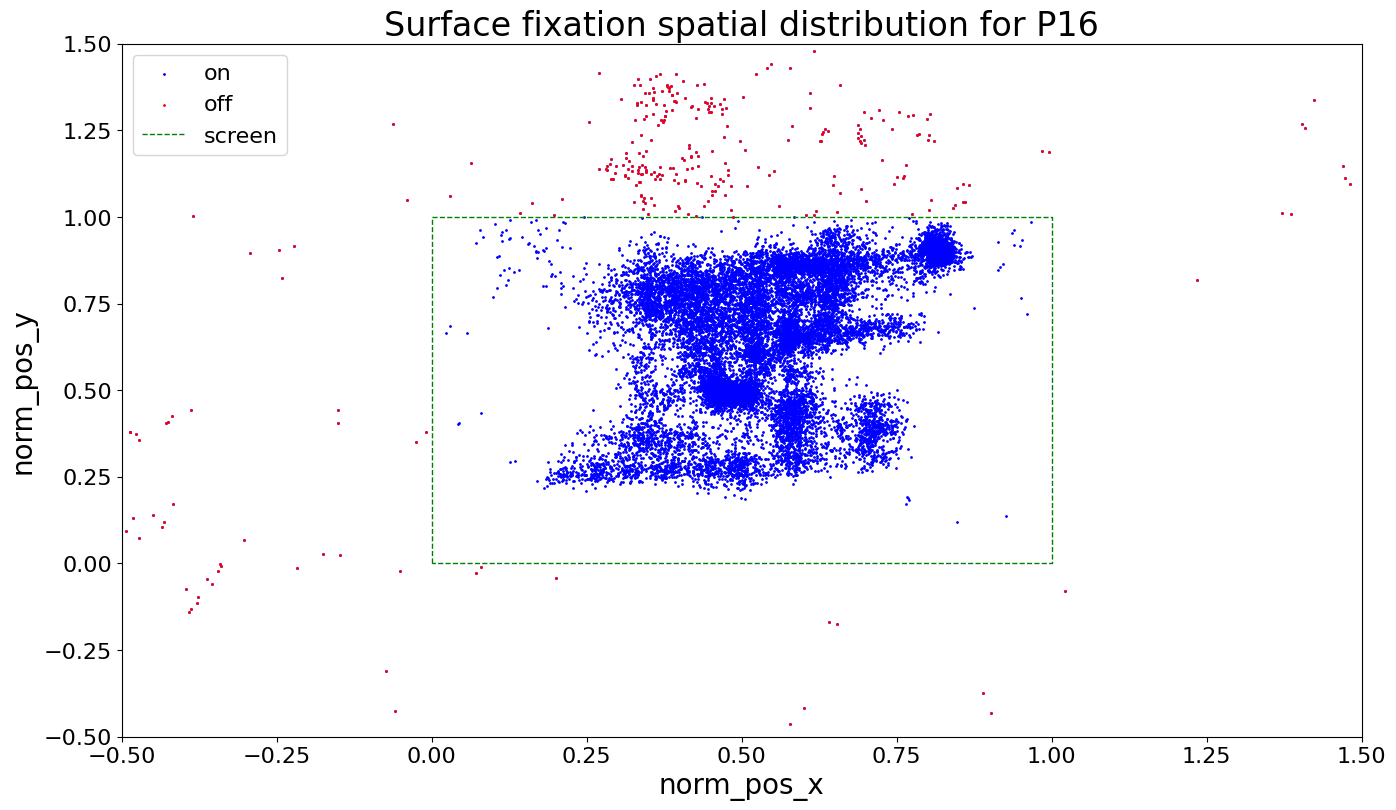

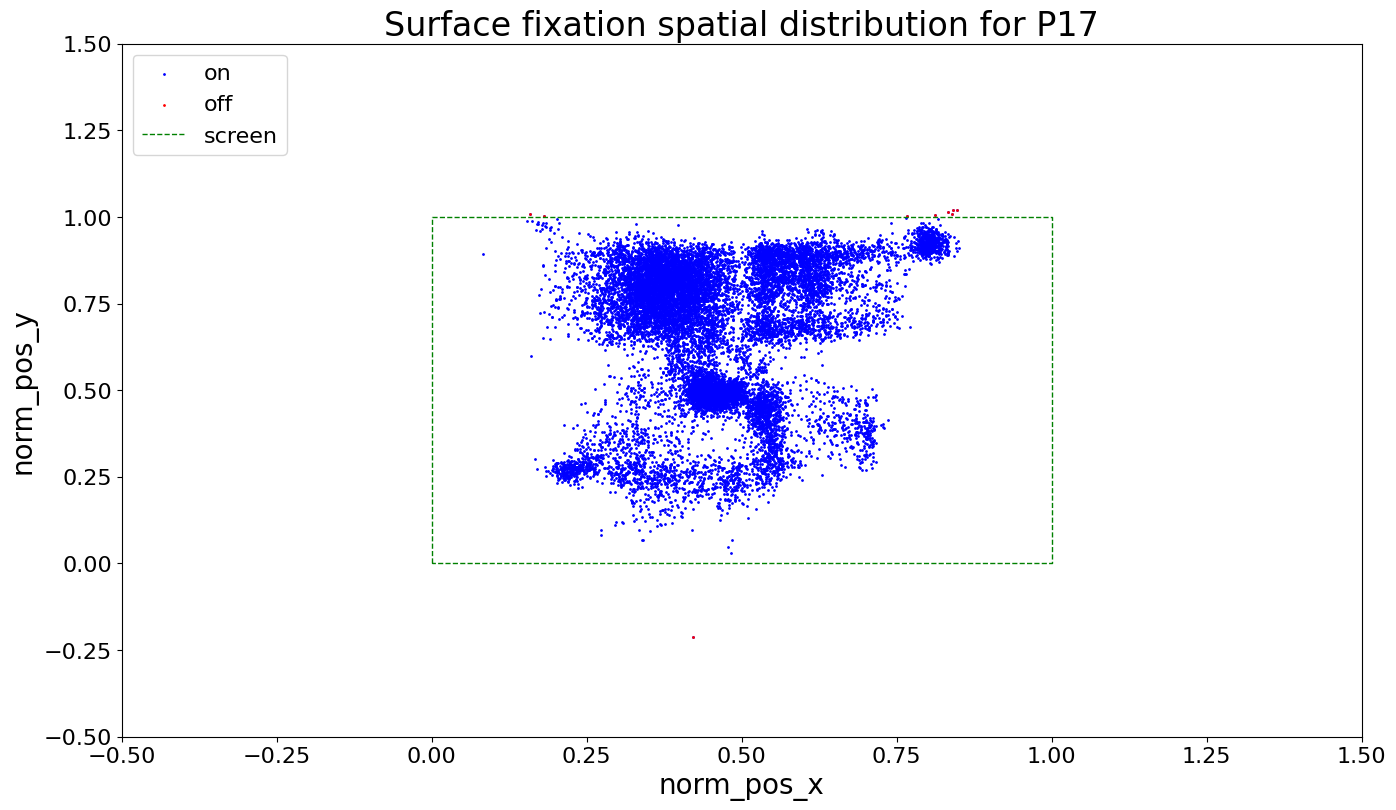

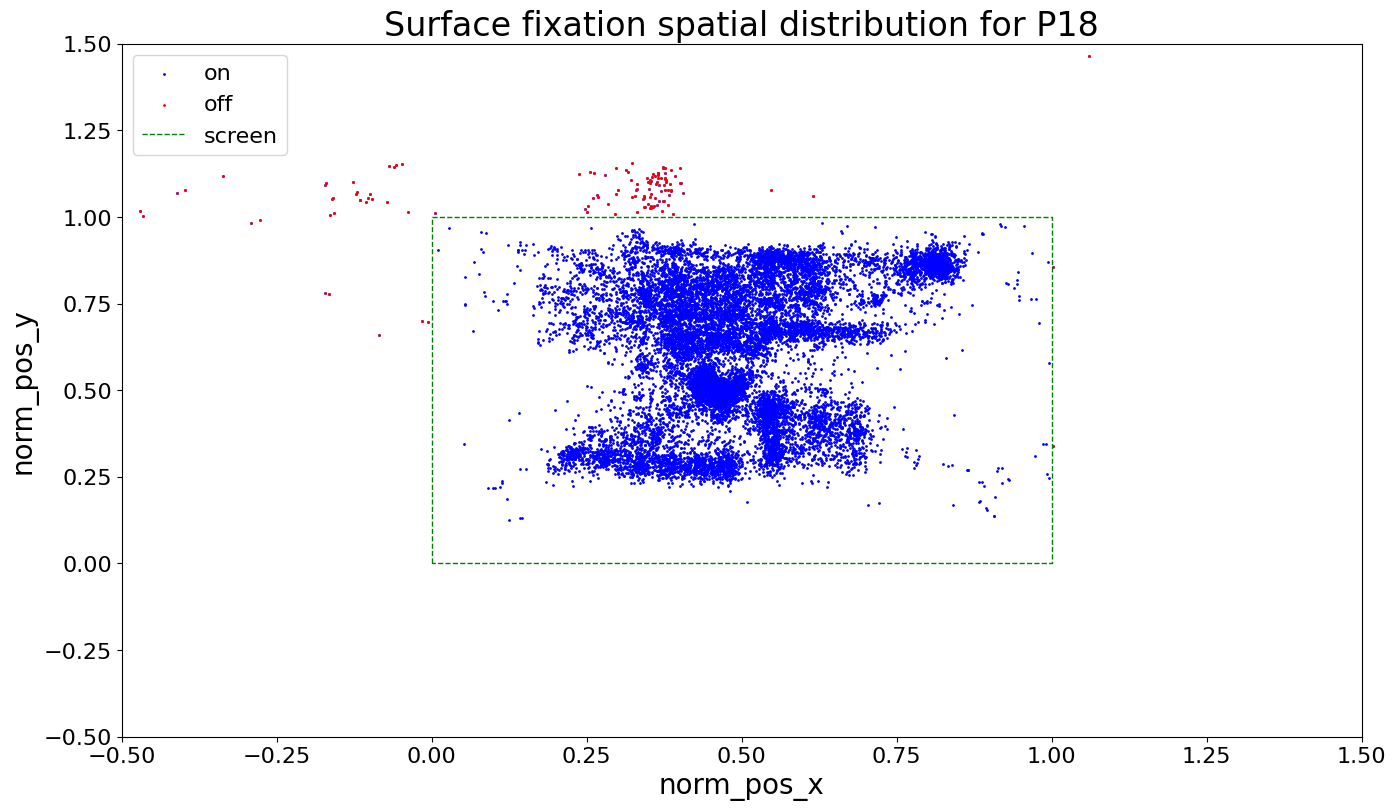

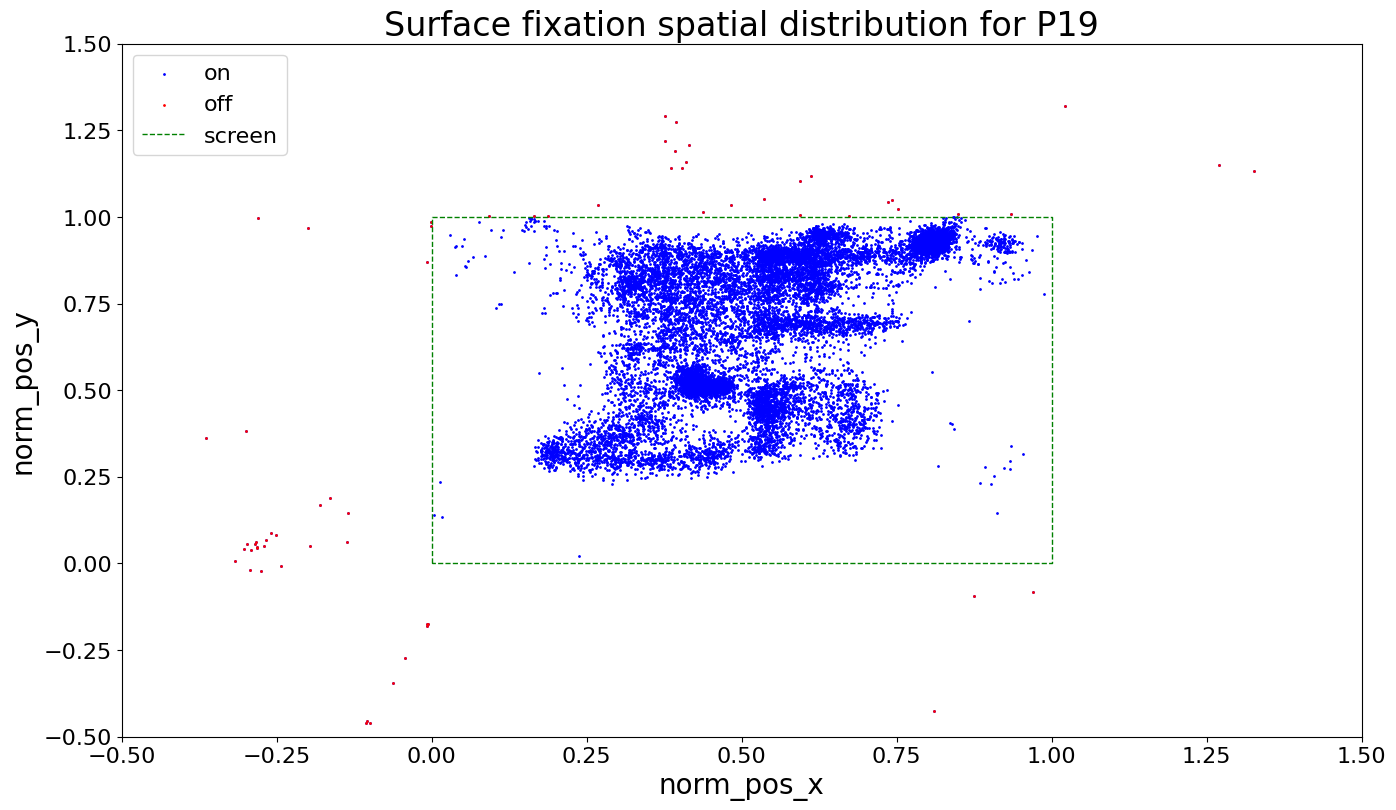

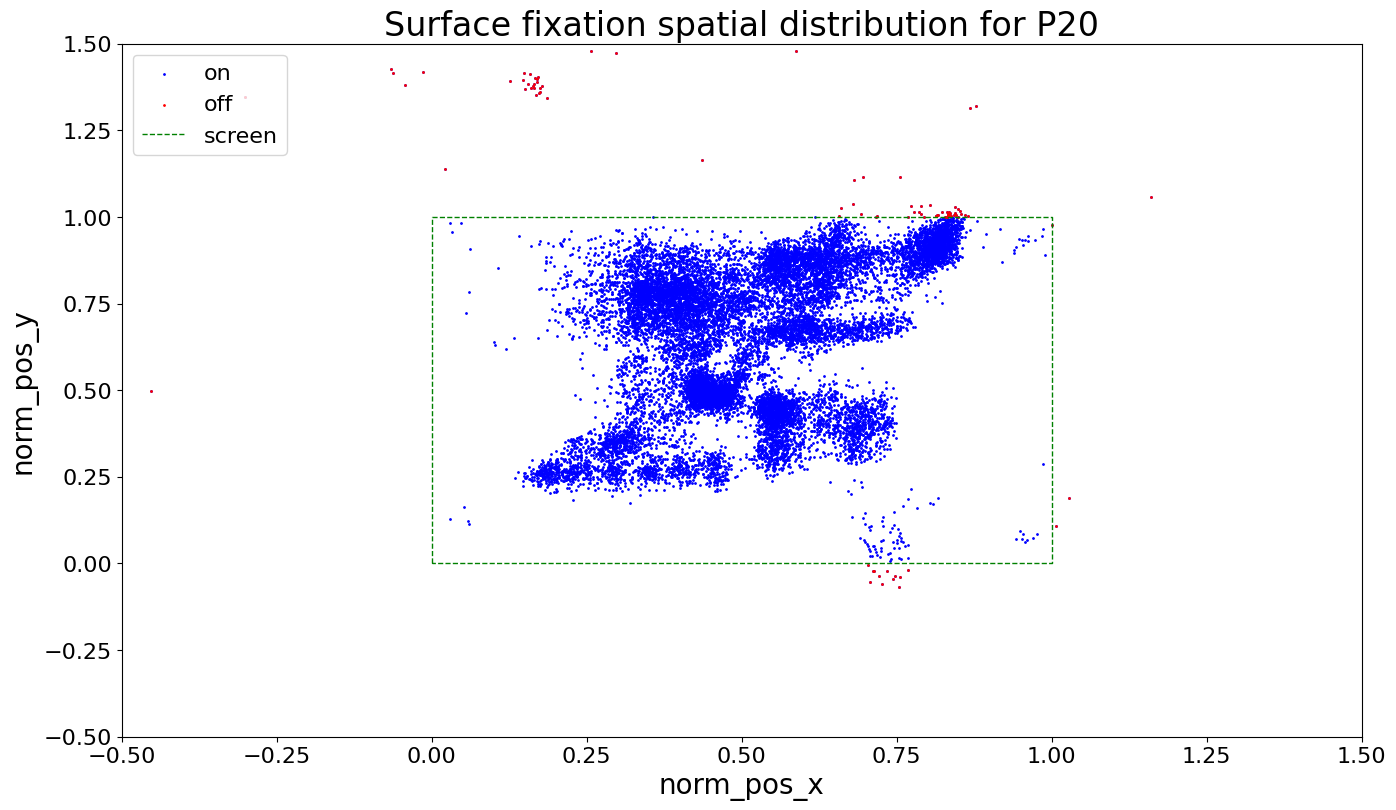

In [15]:
for pid in participant_ids:
    participant_df = df[df['participant_id'] == pid]
    on_surface = participant_df[participant_df['on_surf'] == False]
    plt.figure(figsize=(16, 9))
    
    # Scatter plots
    plt.scatter(participant_df['norm_pos_x'], participant_df['norm_pos_y'], s=1, color='blue', label='on')
    plt.scatter(on_surface['norm_pos_x'], on_surface['norm_pos_y'], s=1, color='red', label='off')
    
    # Draw closed rectangle
    rectangle_x = [0, 0, 1, 1, 0]
    rectangle_y = [0, 1, 1, 0, 0]
    plt.plot(rectangle_x, rectangle_y, color='green', linestyle='--', linewidth=1, label='screen')
    
    # Set title and labels with increased font size
    plt.title(f'Surface fixation spatial distribution for P{pid}', fontsize=24)  # Default ~12
    plt.xlabel('norm_pos_x', fontsize=20)  # Default ~10
    plt.ylabel('norm_pos_y', fontsize=20)  # Default ~10
    
    # Set axis limits
    plt.xlim(-0.5, 1.5)
    plt.ylim(-0.5, 1.5)
    
    # Add legend with increased font size
    plt.legend(loc='upper left', fontsize=16)
    
    # Increase tick sizes
    plt.tick_params(axis='both', which='major', labelsize=16)  # Default ~8-10
    
    # Show plot
    plt.show()


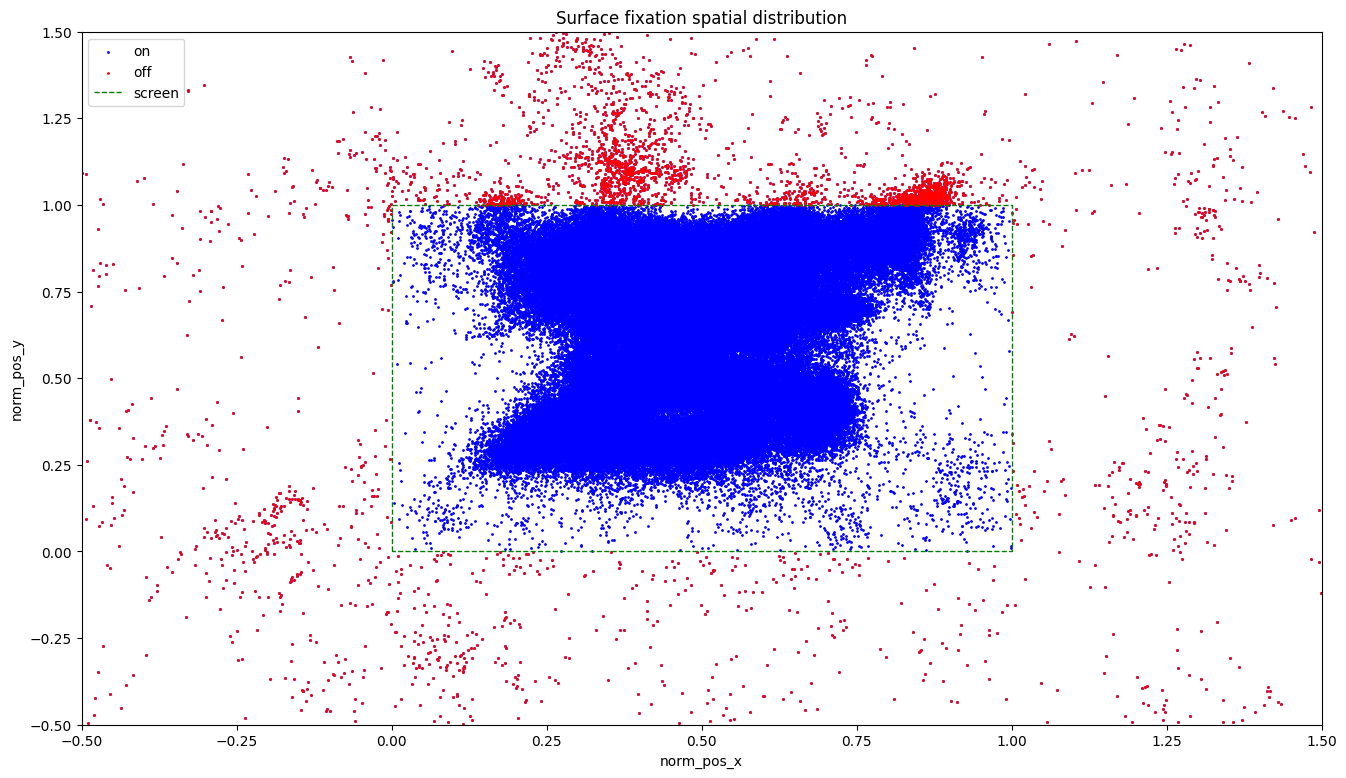

In [32]:
df_clean = df.copy().query('participant_id != 11')
on_surface = df_clean[df_clean['on_surf'] == False]
plt.figure(figsize=(16, 9))
plt.scatter(df_clean['norm_pos_x'], df_clean['norm_pos_y'], s=1, color='blue', label='on')
plt.scatter(on_surface['norm_pos_x'], on_surface['norm_pos_y'], s=1, color='red', label='off')

# Draw closed rectangle
rectangle_x = [0, 0, 1, 1, 0]
rectangle_y = [0, 1, 1, 0, 0]
plt.plot(rectangle_x, rectangle_y, color='green', linestyle='--', linewidth=1, label='screen')

plt.title(f'Surface fixation spatial distribution')
plt.xlabel('norm_pos_x')
plt.ylabel('norm_pos_y')
plt.xlim(-0.5, 1.5)
plt.ylim(-0.5, 1.5)
plt.legend(loc='upper left')
plt.show()

##### Heatmap
- Tendency to look in the middle
- Tendency (smaller) to loon on the top centtral area of the screen (warnings/questionnaires)

In [5]:
# Heatmap df (clamping according to plot axes limits)
heatmap_df = df[(df['norm_pos_x'] >= -.5) & (df['norm_pos_x'] <= 1.5) & (df['norm_pos_y'] >= -.5) & (df['norm_pos_y'] <= 1.5)]

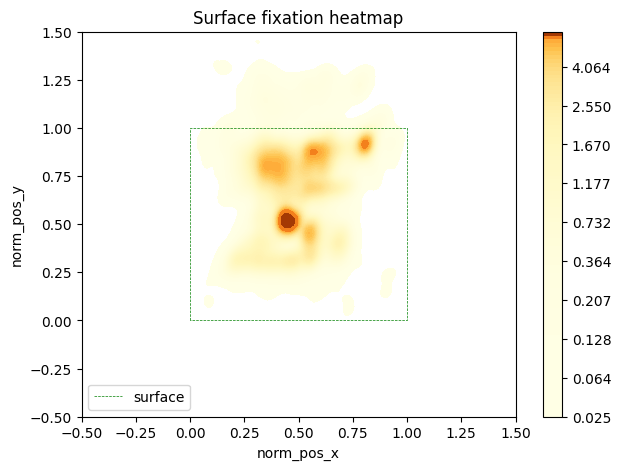

In [7]:
plt.figure(figsize=(7, 5))

# Creating the heatmap
sns.kdeplot(
    x=heatmap_df['norm_pos_x'], 
    y=heatmap_df['norm_pos_y'],
    fill=True, 
    thresh=0,
    levels=np.logspace(-2, 0, 100),
    cmap=sns.color_palette("YlOrBr", as_cmap=True),
    cbar=True
)

# Draw closed rectangle
rectangle_x = [0, 0, 1, 1, 0]
rectangle_y = [0, 1, 1, 0, 0]
plt.plot(rectangle_x, rectangle_y, color='green', linestyle='--', linewidth=0.5, label='surface')

plt.title(f'Surface fixation heatmap')
plt.xlabel('norm_pos_x')
plt.ylabel('norm_pos_y')
plt.xlim(-0.5, 1.5)
plt.ylim(-0.5, 1.5)
plt.legend(loc='lower left')
plt.show()

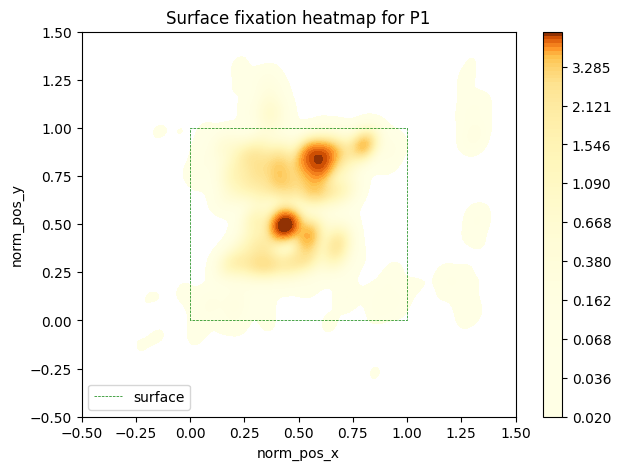

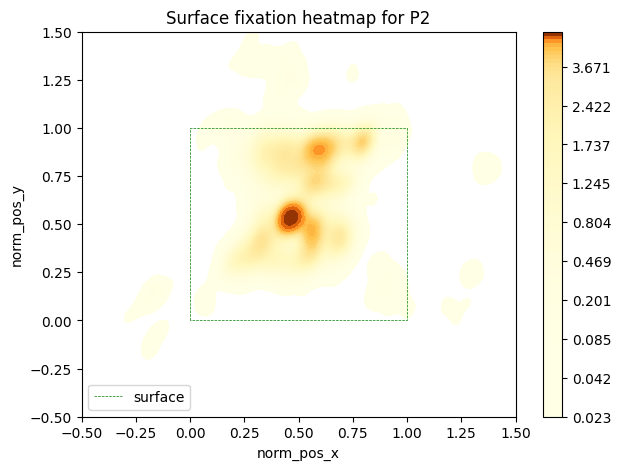

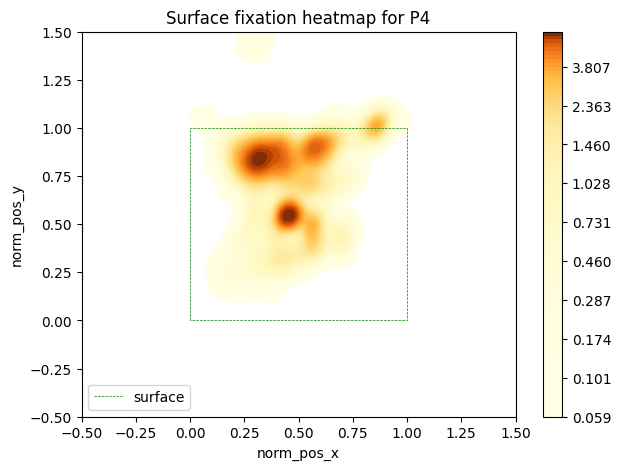

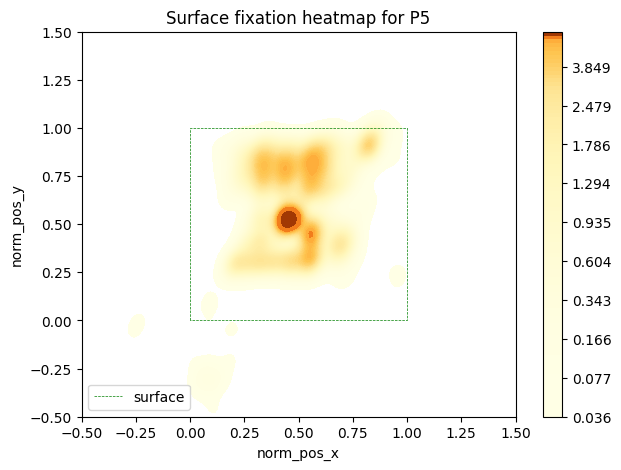

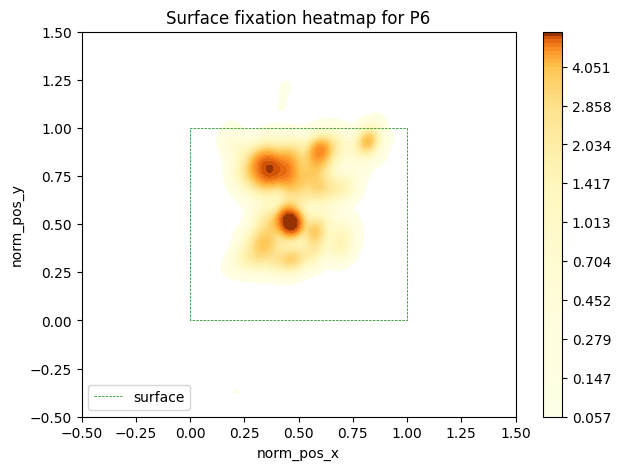

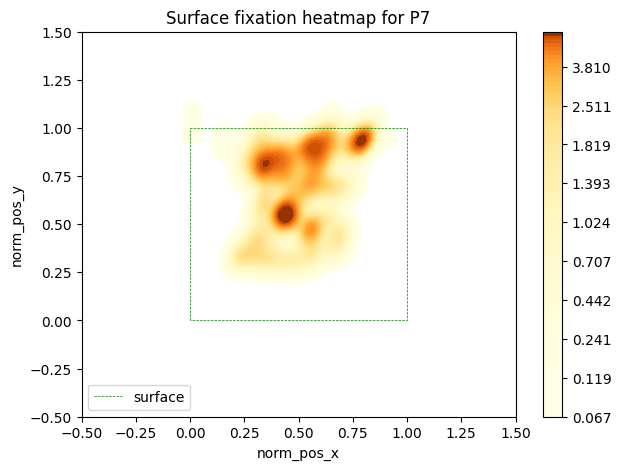

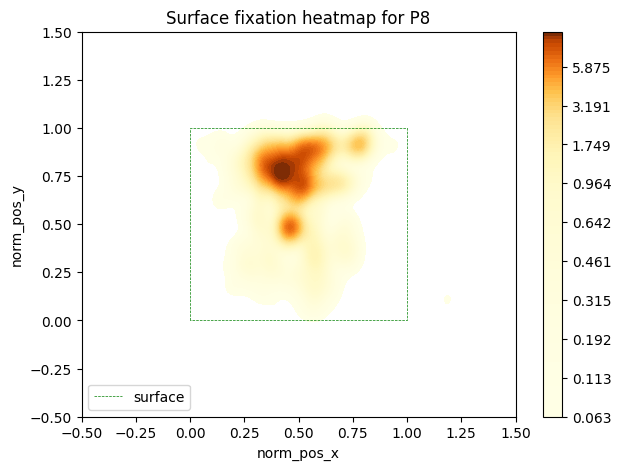

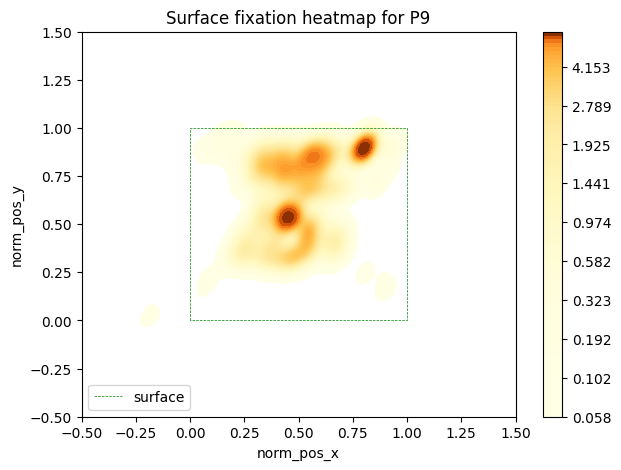

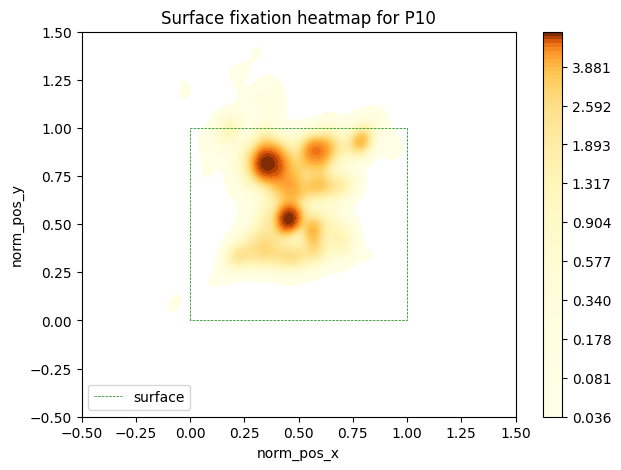

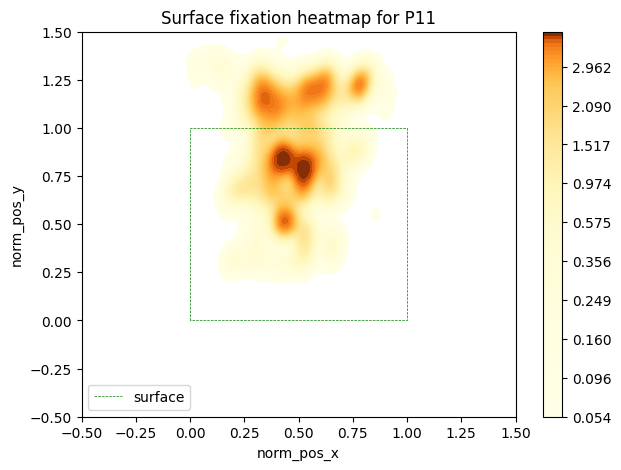

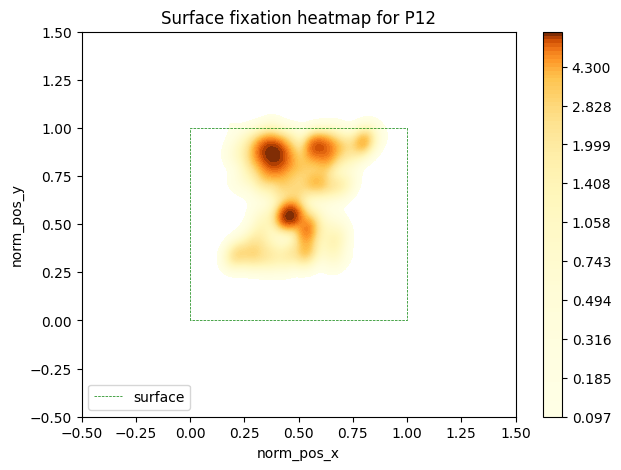

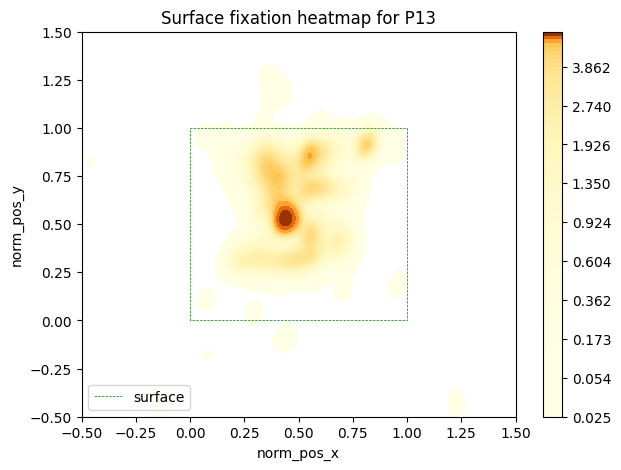

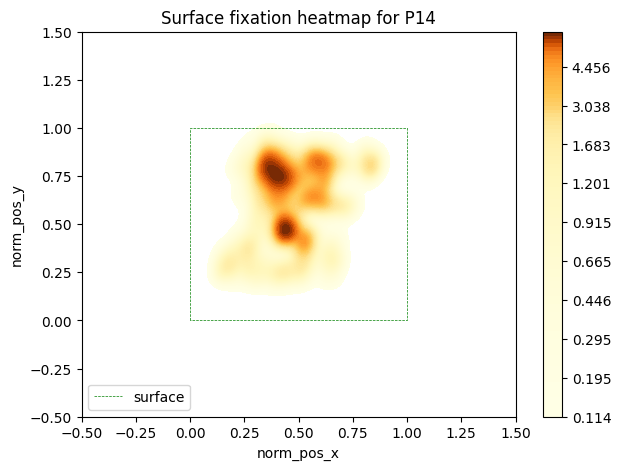

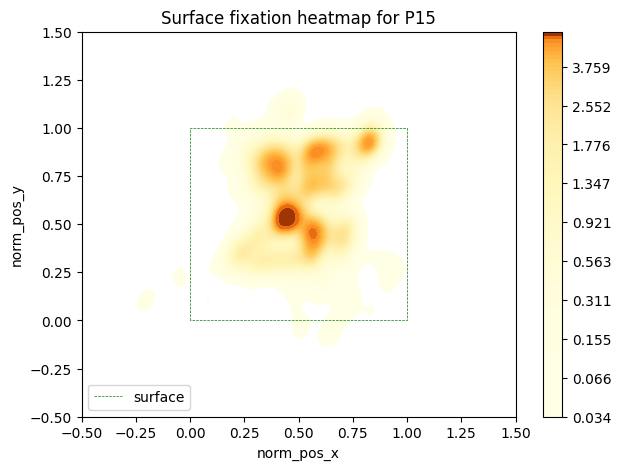

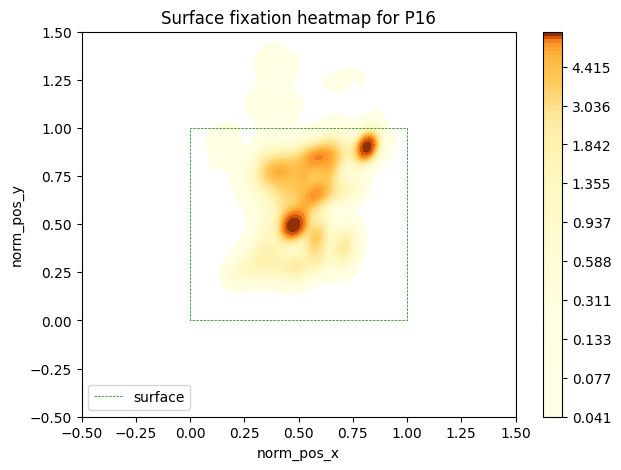

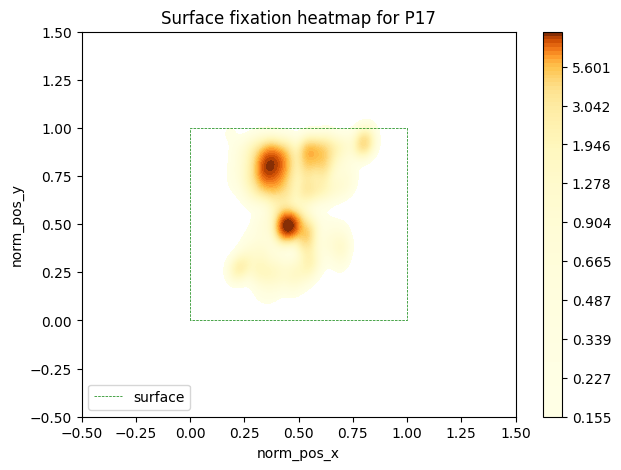

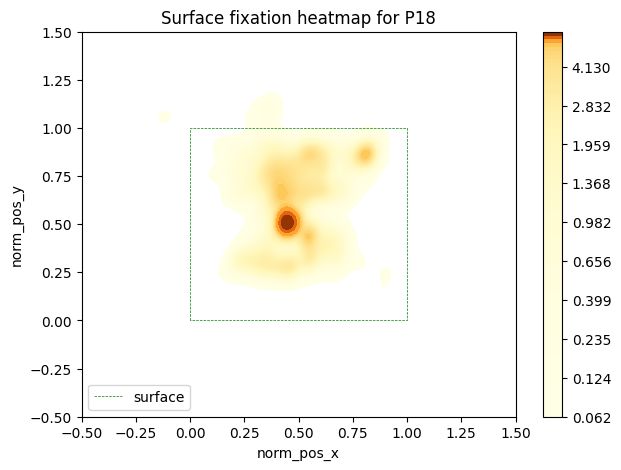

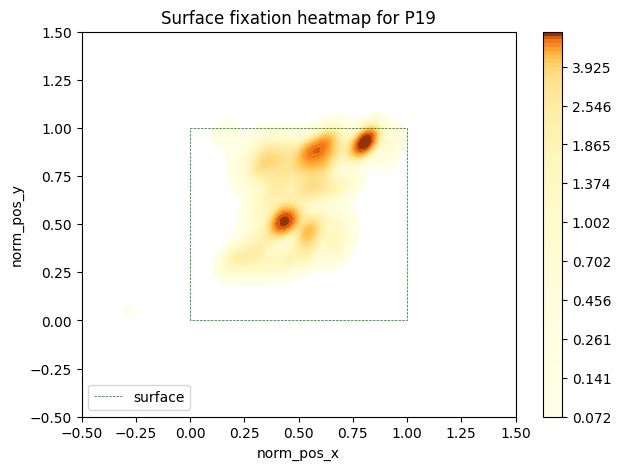

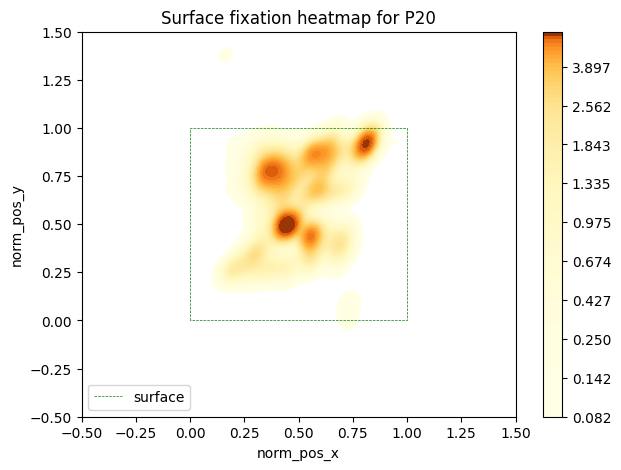

In [8]:
for pid in participant_ids:
    participant_df = heatmap_df[heatmap_df['participant_id'] == pid]

    plt.figure(figsize=(7, 5))

    # Creating the heatmap
    sns.kdeplot(
        x=participant_df['norm_pos_x'], 
        y=participant_df['norm_pos_y'],
        fill=True, 
        thresh=0,
        levels=np.logspace(-2, 0, 100),
        cmap=sns.color_palette("YlOrBr", as_cmap=True),
        cbar=True
    )

    # Draw closed rectangle
    rectangle_x = [0, 0, 1, 1, 0]
    rectangle_y = [0, 1, 1, 0, 0]
    plt.plot(rectangle_x, rectangle_y, color='green', linestyle='--', linewidth=0.5, label='surface')

    plt.title(f'Surface fixation heatmap for P{pid}')
    plt.xlabel('norm_pos_x')
    plt.ylabel('norm_pos_y')
    plt.xlim(-0.5, 1.5)
    plt.ylim(-0.5, 1.5)
    plt.legend(loc='lower left')
    plt.show()

### 3. Time-Series Assessment
Duration, Dispersion, Normalized position, (off-)Occurences

##### Normalized position over time
- Questionnaires might be detectable by smaller position changes over time (in some participants, ex. P4, P5, P18)
- Not useful to plot off_surface

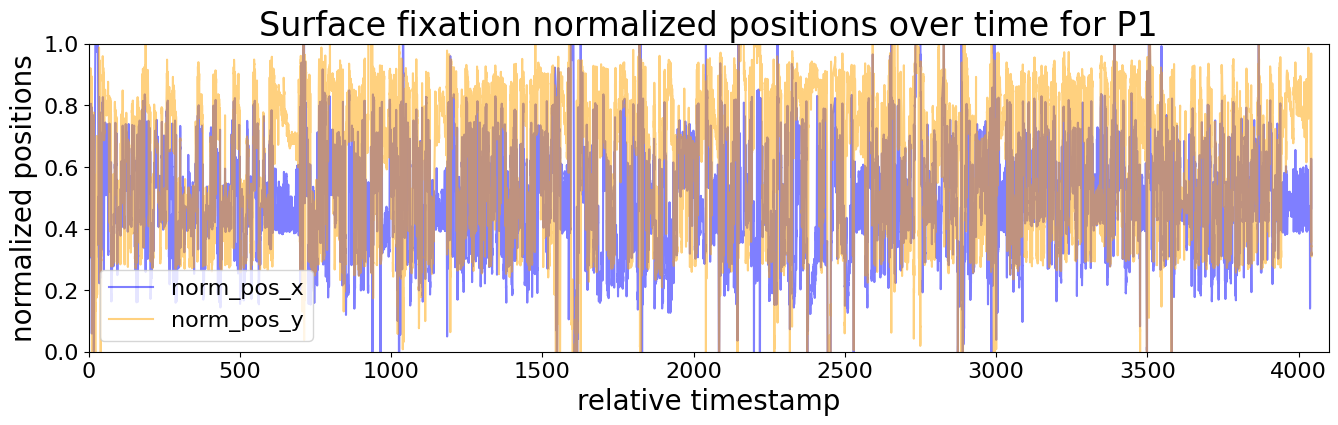

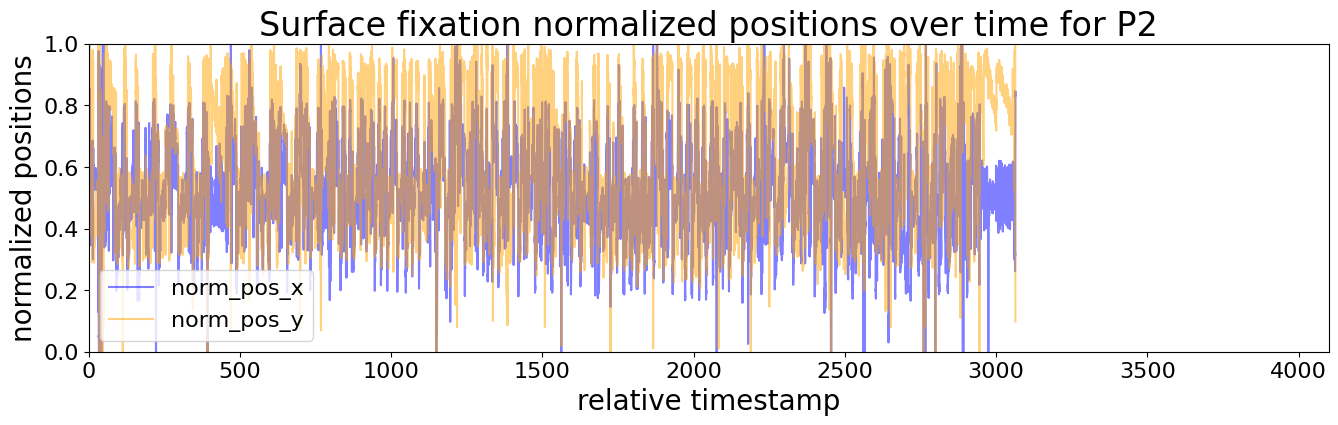

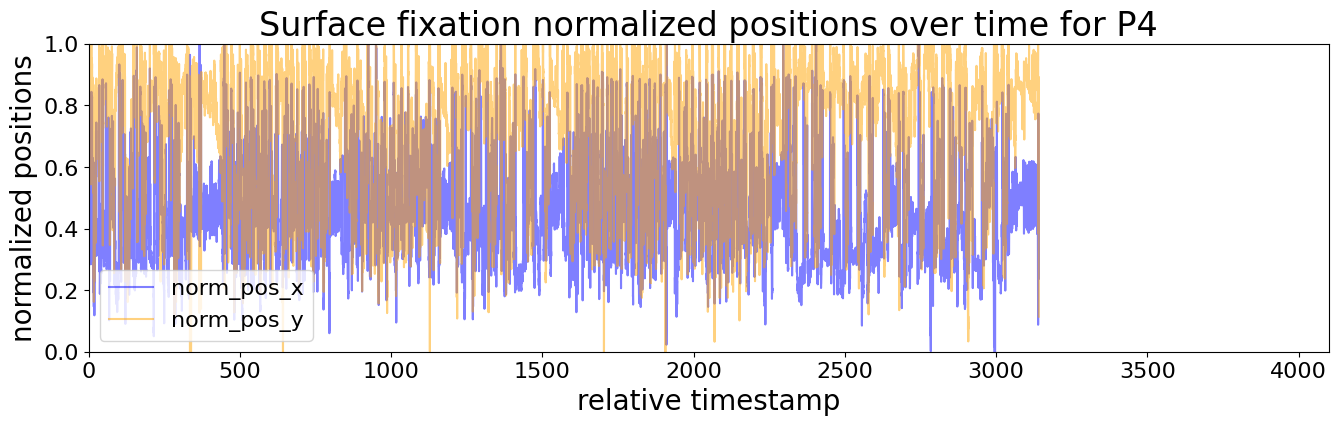

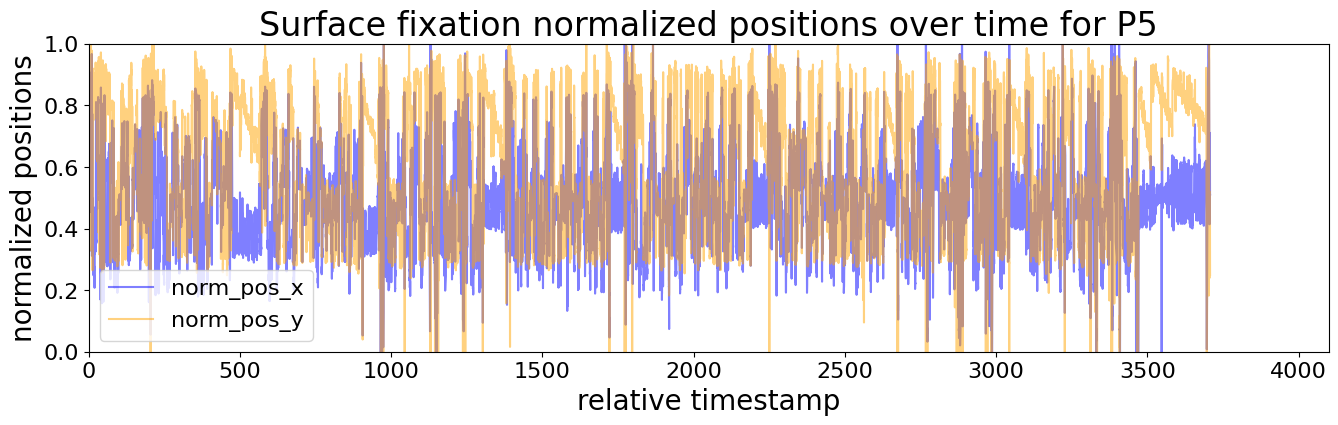

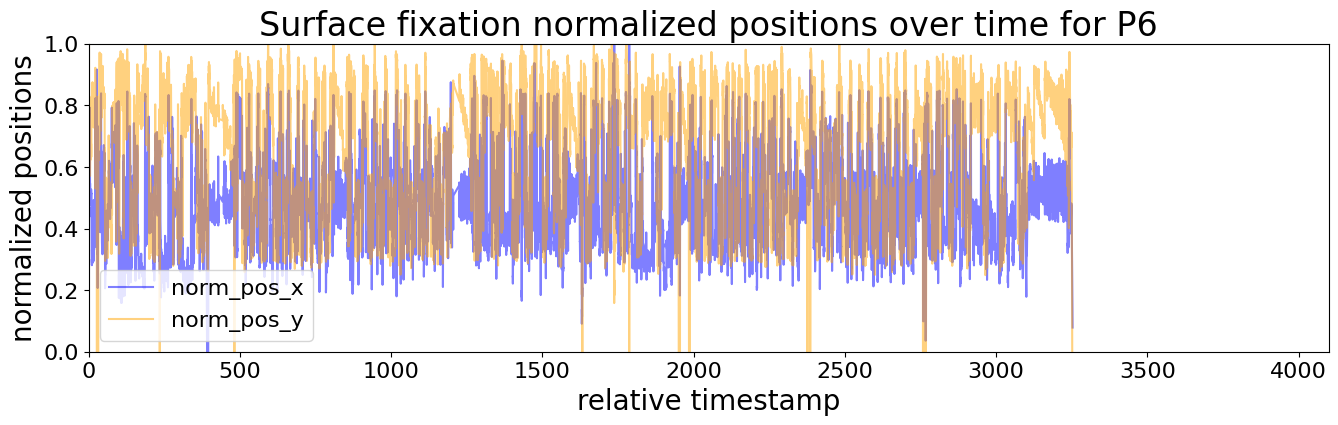

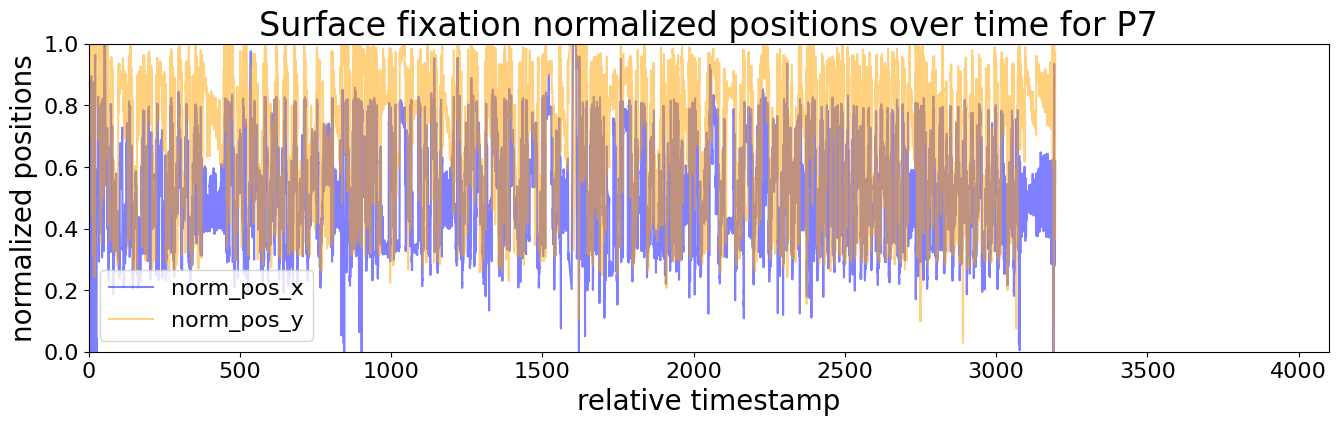

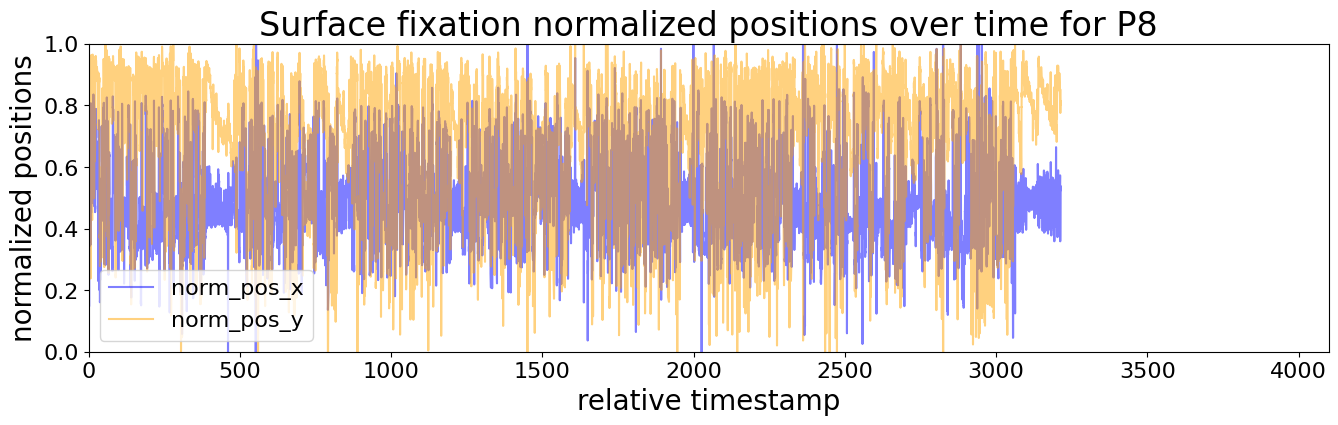

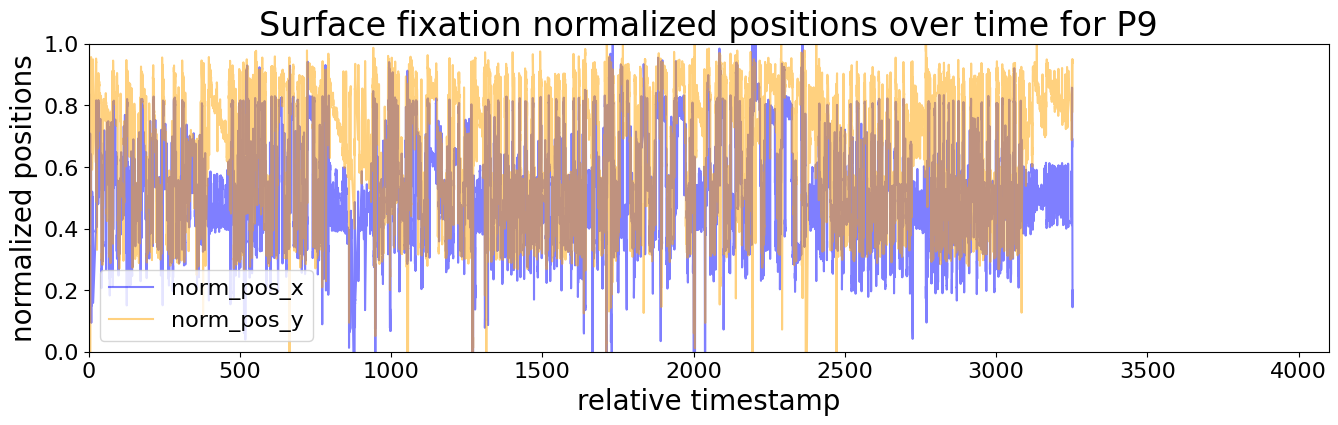

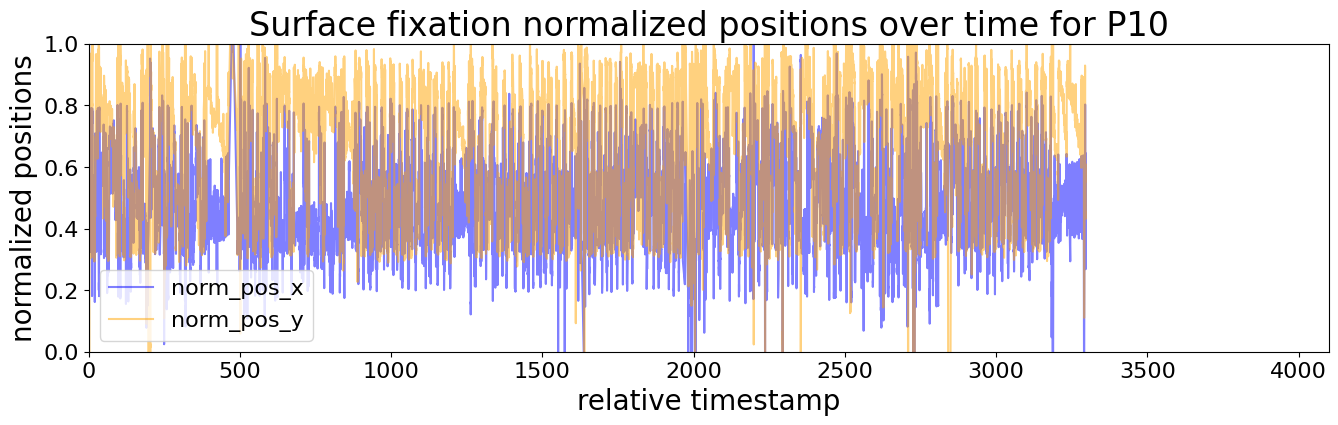

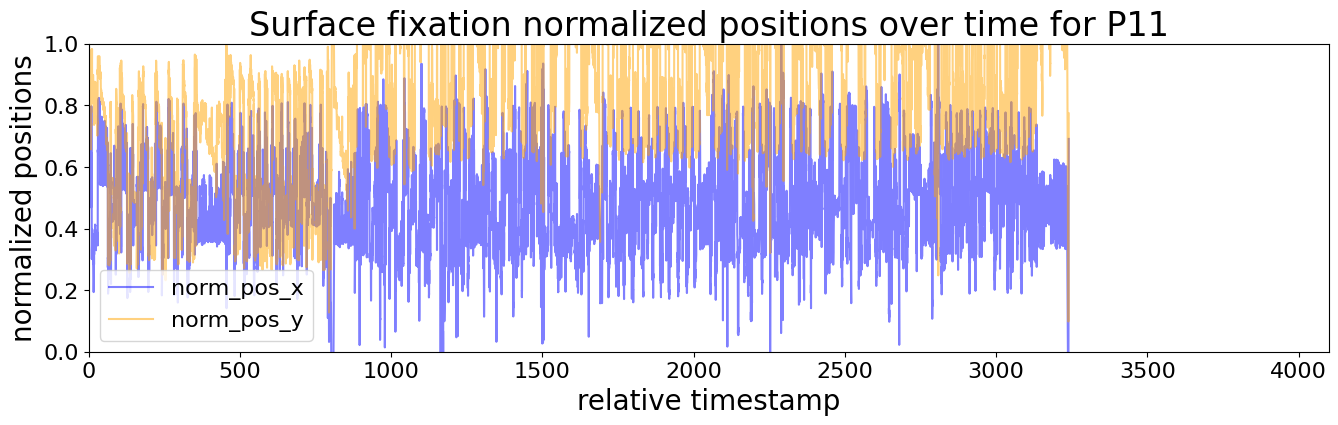

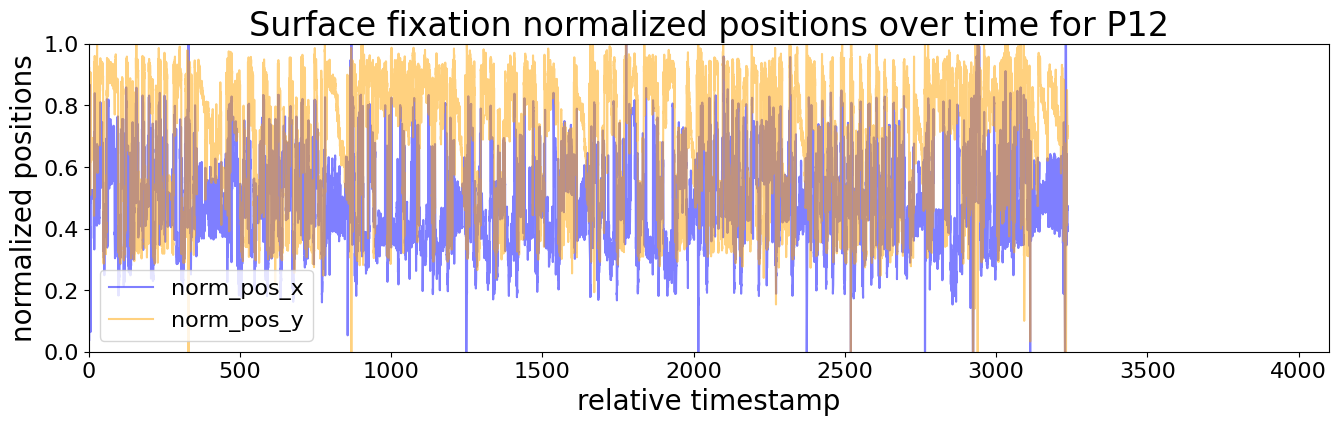

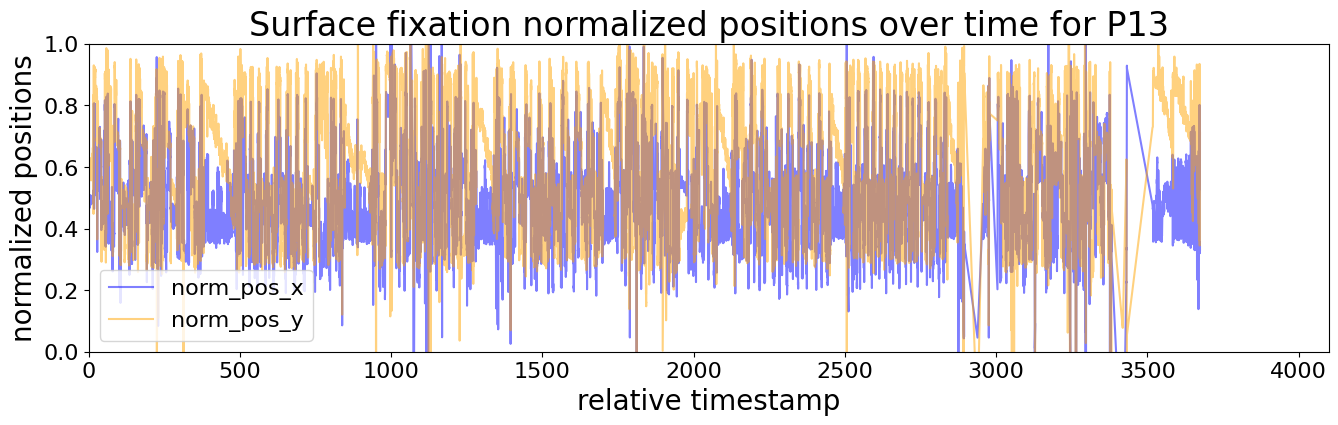

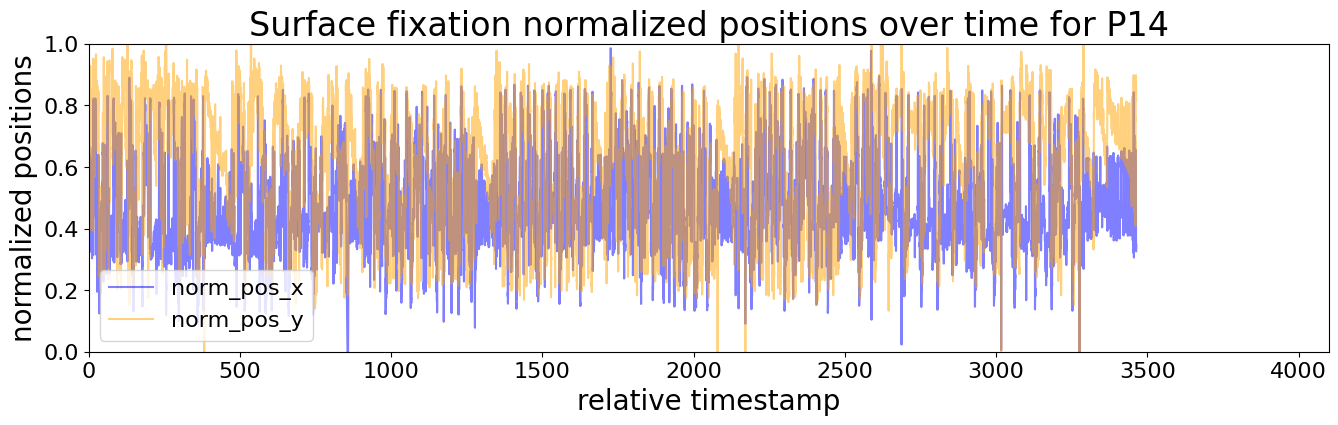

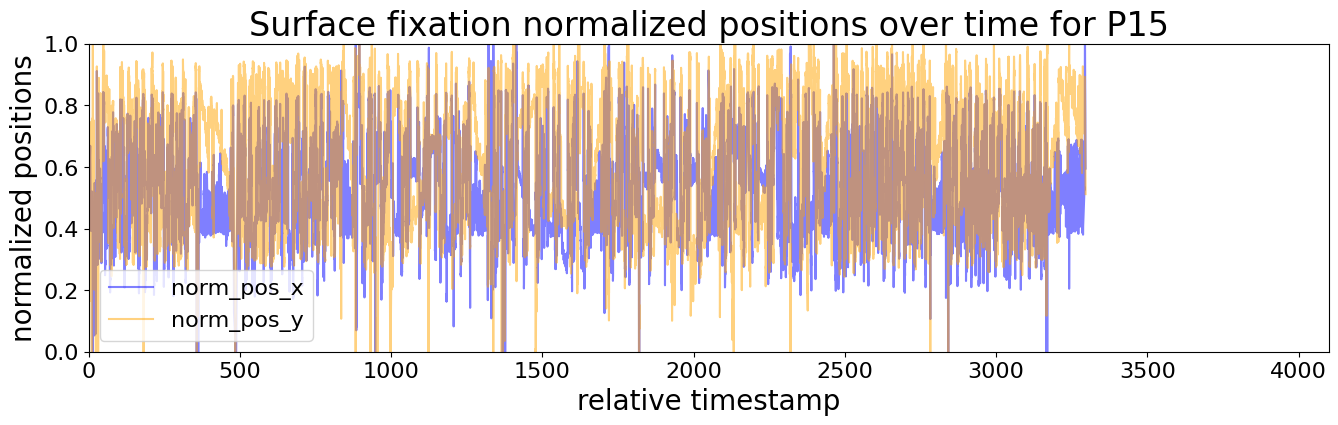

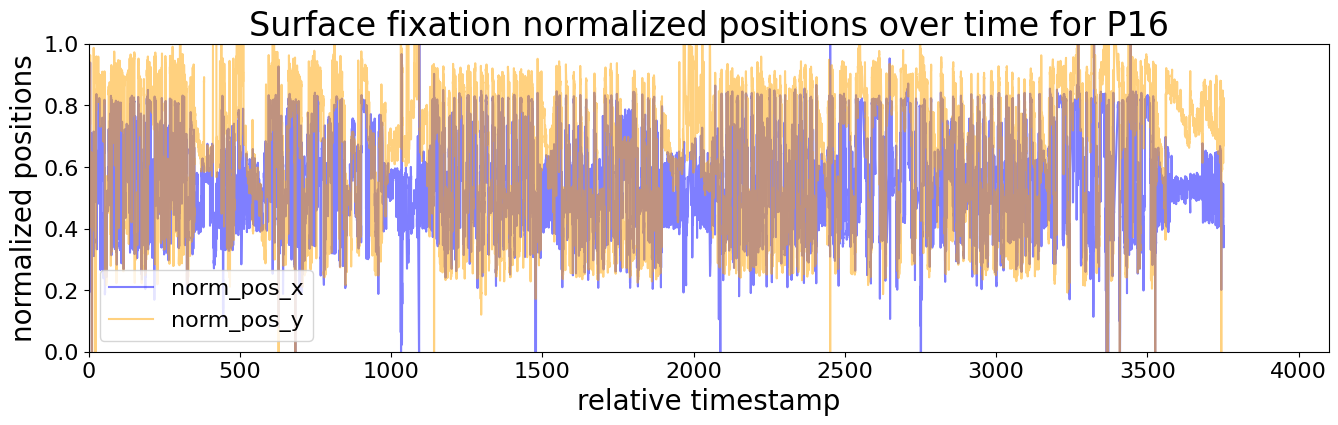

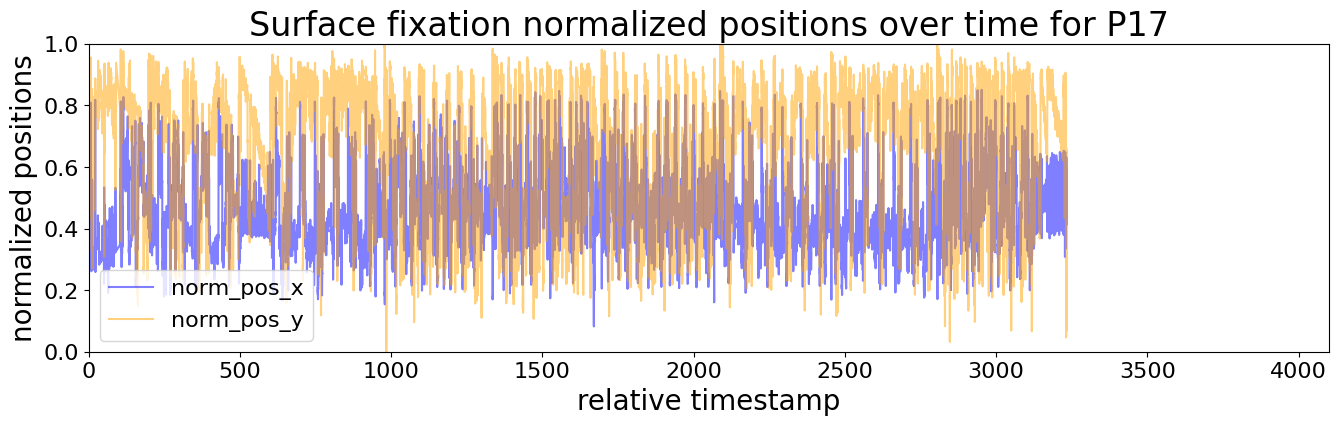

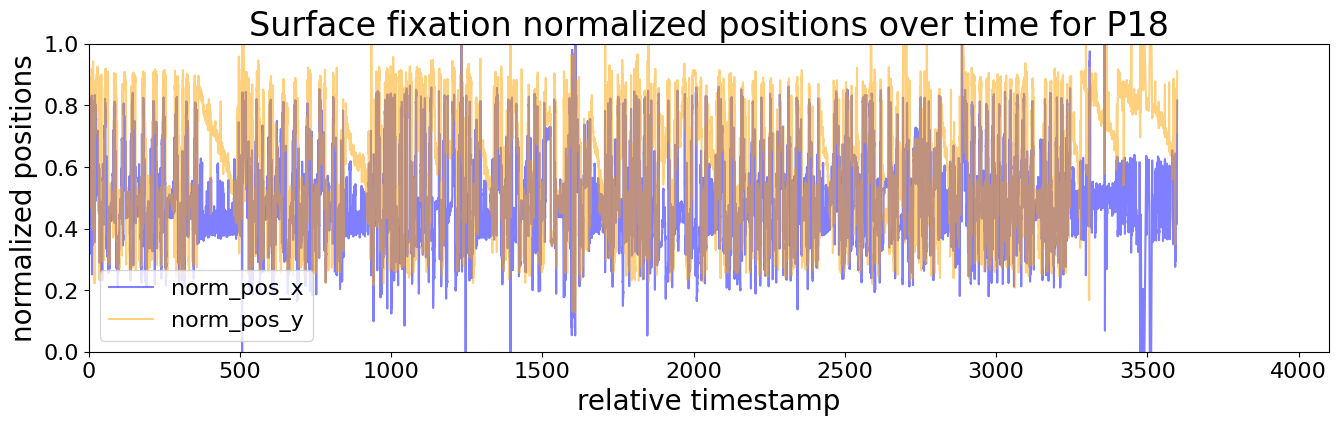

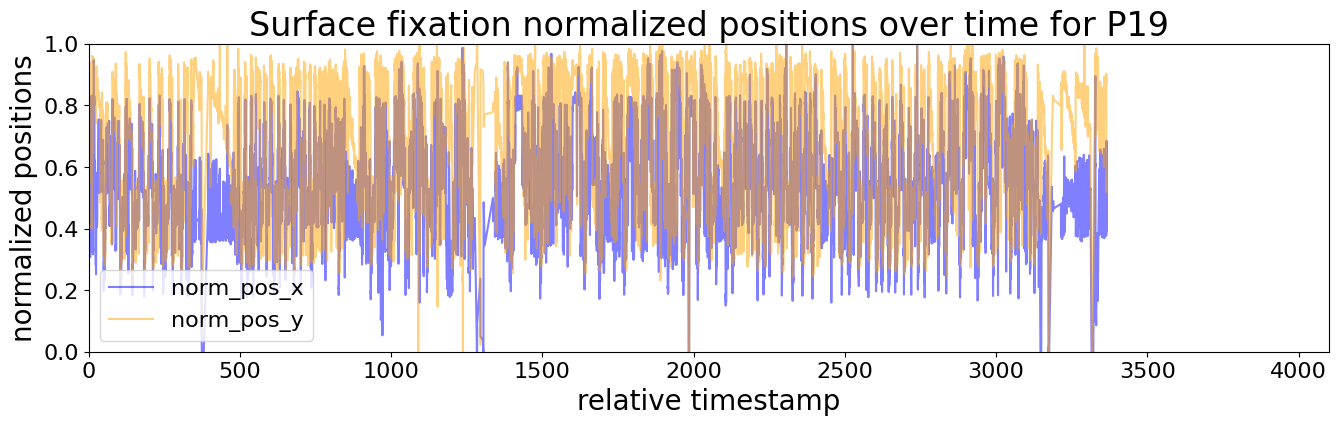

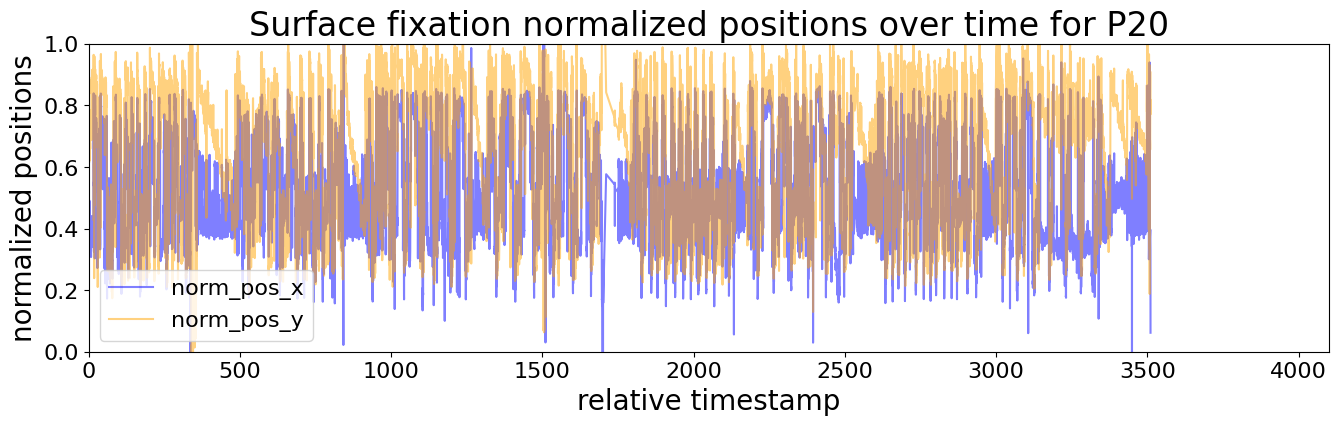

In [14]:
for pid in participant_ids:
    participant_df = df[df['participant_id'] == pid]
    plt.figure(figsize=(16, 4))
    
    plt.plot(participant_df['relative_timestamp'], participant_df['norm_pos_x'], alpha=0.5, color='blue', label='norm_pos_x')
    plt.plot(participant_df['relative_timestamp'], participant_df['norm_pos_y'], alpha=0.5, color='orange', label='norm_pos_y')
    
    plt.title(f'Surface fixation normalized positions over time for P{pid}', fontsize=24)
    plt.xlabel('relative timestamp', fontsize=20)
    plt.ylabel('normalized positions', fontsize=20)
    plt.xlim(0, 4100)
    plt.ylim(0, 1)
    plt.legend(loc='lower left', fontsize=16)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.show()

##### Off-screen occurences
- Multiple off-surface fixations, what happen? (artifact?)

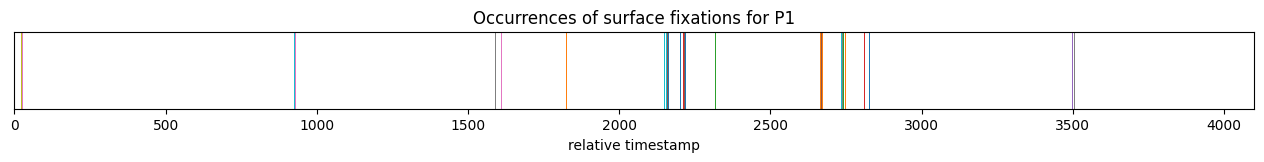

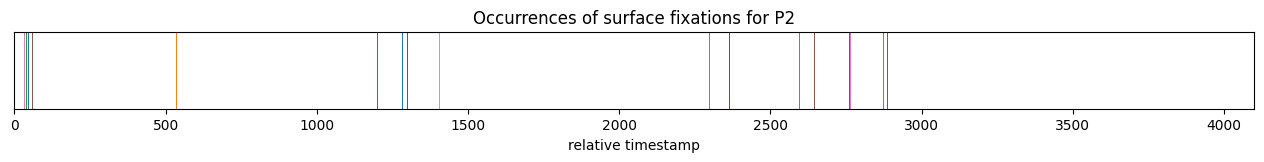

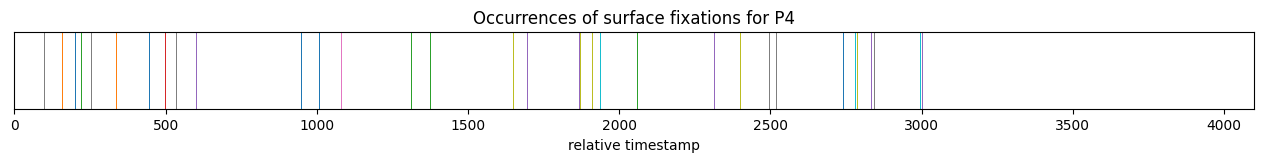

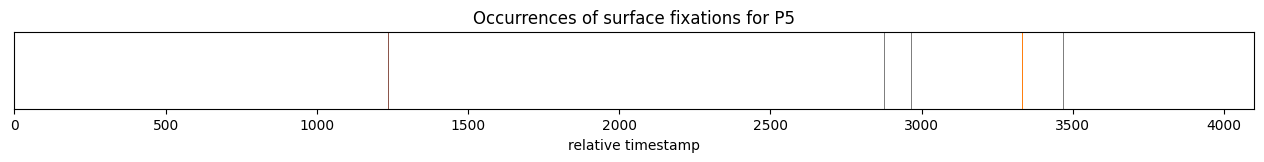

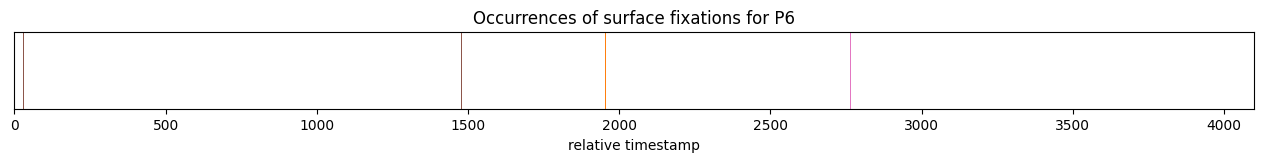

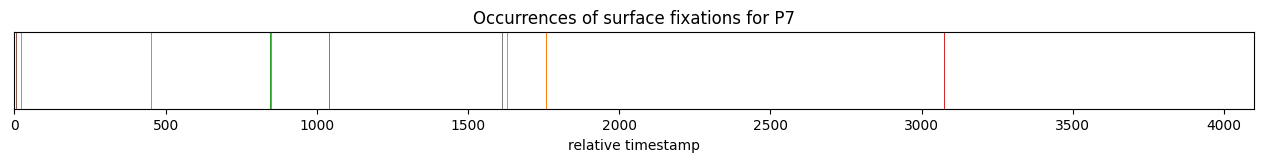

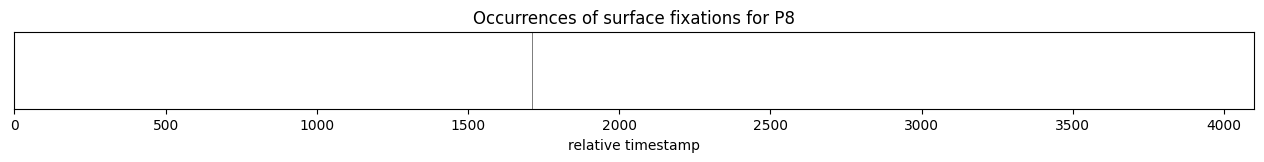

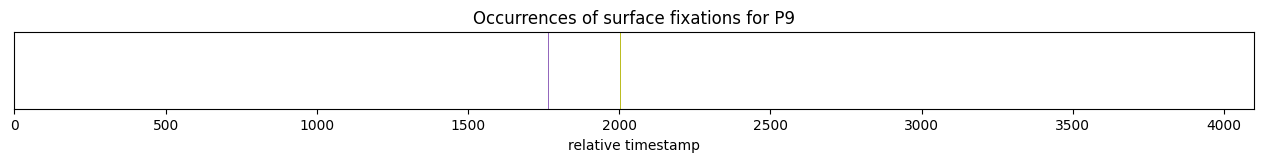

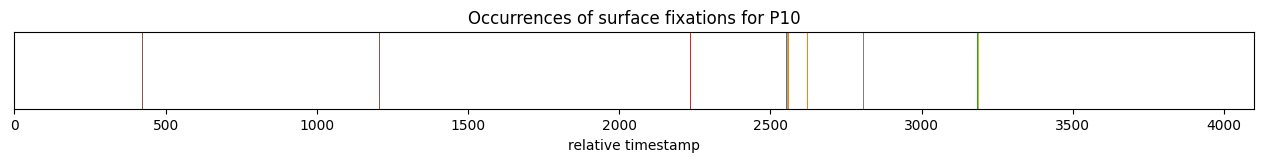

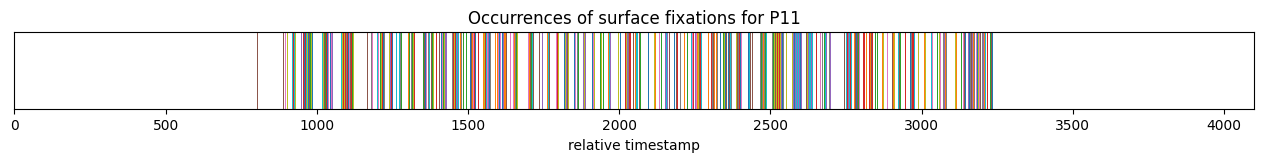

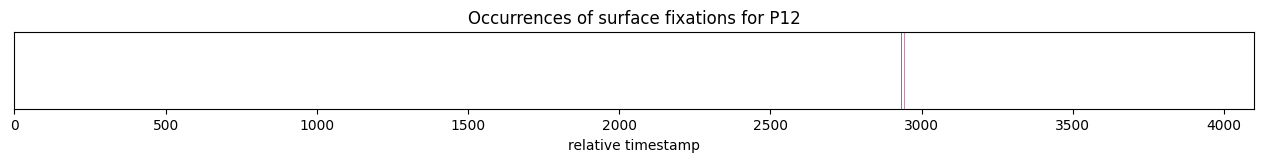

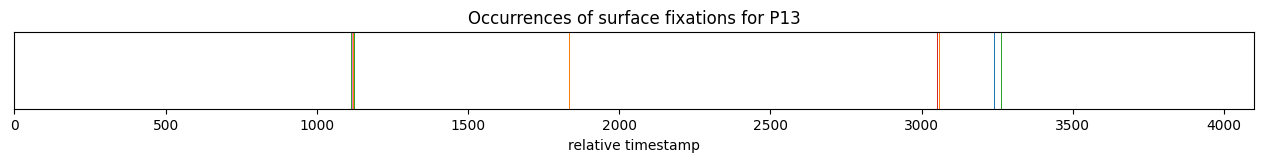

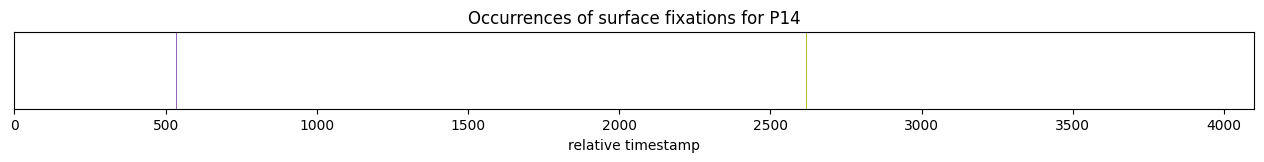

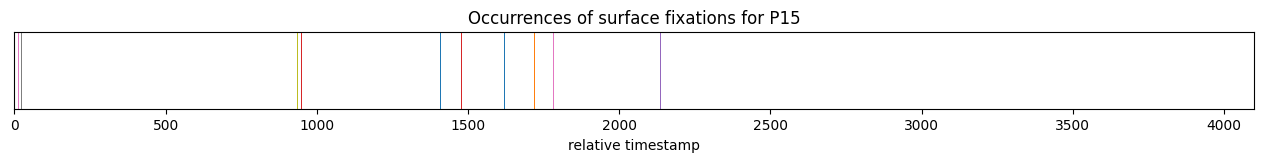

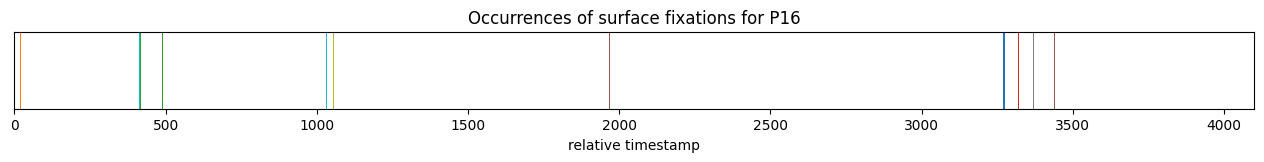

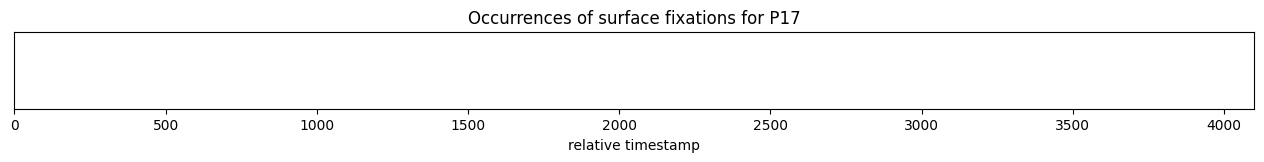

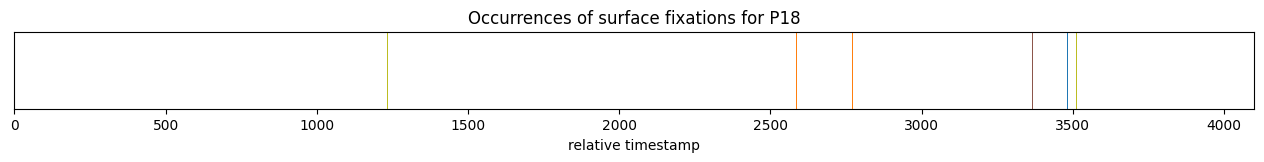

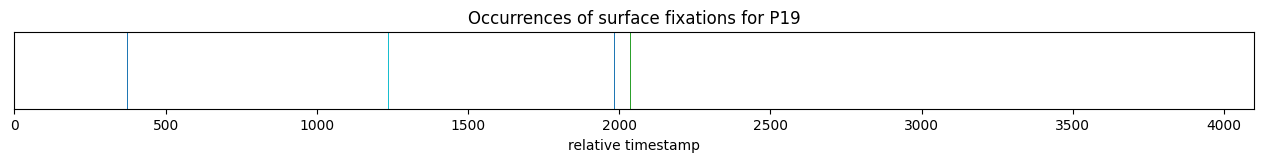

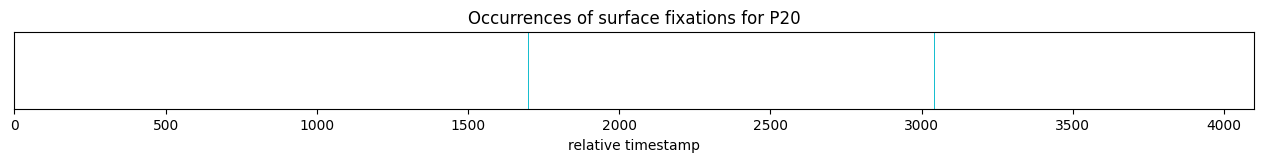

In [16]:
for pid in participant_ids:
    participant_off_df = df[(df['participant_id'] == pid) & (df['on_surf'] == False)]
    plt.figure(figsize=(16, 1))
    for _, row in participant_off_df.iterrows():
        start = row['relative_timestamp']
        duration = row['duration']/1000 #from [ms] to [s]
        plt.bar(start, 0.5, duration, align='edge')
    plt.title(f'Occurrences of surface fixations for P{pid}')
    plt.xlabel('relative timestamp')
    plt.xlim(0, 4100)
    plt.ylim(0, 0.5)
    plt.gca().get_yaxis().set_visible(False)
    plt.show()